# Does Betting Against Beta Work in China? 
## *NUS-PKU Financial Engineering* Project

### DING Xiangyu

# Data
In this project, I need daily return data of all the Chinese stocks to construct betting-against-beta factor portfolio. Also, we need data of other return factors in China as controls.

The daily return comes from Wind Data Service (WDS) FileSync database maintained by Chinese financial data service provider Wind Information Co., Ltd. It is popular in Chinese financial market. https://www.wind.com.cn/en/data.html is the webpage of their data service. Our business school subscribes to this database and we can only access data when connected to the wifi in our school building. It is an Oracle based database so we can use SQL to query data from it.  

The market return we used to estimate the beta of each stocks comes from academic paper *Size and value in China* by Stambaugh et. al. (2019) published on *Journal of Financial Economics*. Dr. Robert F. Stambaugh post their estimated result on his webpage: https://finance.wharton.upenn.edu/~stambaug/.  

In order to control the influence of other factors on the rate of return, we use common return factors as control, including Fama & French (1993) three factors, Carhart (1997) four factors, and Fama and French (2015) five factors. Shi et al. (2020) calculate the returns of these factors in the Chinese stock market in their book *Factor Investing*. They publish their data at https://www.factorwar.com/data/factor-models/.


# Data Preprocessing

In [1]:
import pandas as pd
import os
import numpy as np
import scipy
import datetime
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline


df_4factor = pd.read_csv("Data/Original/CH_4_fac_daily_update_20201231.csv", header=9)
df_3factor = pd.read_csv("Data/Original/CH_3_fac_daily_update_20201231.csv", header=8)

# loading data we query from the Wind FileSync Database
df = pd.read_parquet("Data/Original/PriceData_withInfo.parquet")

# loading market valuation data
    # s_val_mv: total market value
    # s_dq_mv:  total circulation market value
df_valuation = pd.read_parquet("Data/Extension/valuation/valuation1.parquet")
df_valuation = df_valuation[["trade_dt", "s_info_windcode", "s_val_mv", "s_dq_mv"]]


# Convert the date string into a pandas DateTime Object.
df_4factor["date"] = pd.to_datetime(df_4factor["date"], format="%Y%m%d")
df_3factor["date"] = pd.to_datetime(df_3factor["date"], format="%Y%m%d")
df["date"] =  pd.to_datetime(df["trade_dt"], format="%Y%m%d")
df_valuation["date"] =  pd.to_datetime(df_valuation["trade_dt"], format="%Y%m%d")

# Calculate the daily stock return.
df["return"] = (df["s_dq_adjclose"]-df["s_dq_adjpreclose"])/df["s_dq_adjpreclose"]

# slice the dataframe
df = df[["s_info_windcode","date", "return"]]
df_valuation = df_valuation[["s_info_windcode","date","s_val_mv","s_dq_mv"]]

# Notice that in `df_4factor`, represented as percentage value
# Therefore, we need to divide 100
df_4factor["rf_dly"] = df_4factor["rf_dly"]/100
df_4factor["mktrf"] = df_4factor["mktrf"]/100
df_4factor["VMG"] = df_4factor["VMG"]/100
df_4factor["SMB"] = df_4factor["SMB"]/100
df_4factor["PMO"] = df_4factor["PMO"]/100

# some discriptive statistics
print("The 0.1% percentile of daily return is {} %".format(df["return"].quantile(0.001)*100))
print("The 99.9% percentile of daily return is {} %".format(df["return"].quantile(0.999)*100))
print("The min of daily return is {} %".format(df["return"].min()*100))
print("The max of daily return is {} %".format(df["return"].max()*100))

df["return_original"] = df["return"]

quantile_001 = df["return"].quantile(0.001)
quantile_999 = df["return"].quantile(0.999)
(df["return"])[df["return"] < quantile_001] = quantile_001
(df["return"])[df["return"] > quantile_999] = quantile_999

print("The min of daily return after truncation is {} %".format(df["return"].min()*100))
print("The max of daily return after truncation is {} %".format(df["return"].max()*100))

# A feature of the original datast is that if a stock is not trading at specific date 
# due to trading suspension, or a stock has not yet been listed on that day, 
# they does not occur in the database as a column.
# However, we want the stock occur as a column but with NaN value. 
# We can do this by using the pd.pivot and pd.stack(dropna=False).
df_pivot = df.pivot(index="date",
                    columns="s_info_windcode",
                    values=["return", "return_original"])
df_1_fillNaN = df_pivot.stack(dropna=False).reset_index().rename({0: "return"}, axis=1)

df = pd.merge(left=df_1_fillNaN,
              right=df_valuation,
              on=["date","s_info_windcode"],
              how= 'left')

df = pd.merge(df,
              df_4factor[["date","rf_dly", "mktrf"]],
              on="date",
              how='inner')

# Calculate the excess return
df["excess_return"] = df["return"] - df["rf_dly"]
df["excess_return_original"] = df["return_original"] - df["rf_dly"]

The 0.1% percentile of daily return is -10.031746031746032 %
The 99.9% percentile of daily return is 10.138248847926269 %
The min of daily return is -68.72913686218408 %
The max of daily return is 2065.2866242038217 %


<ipython-input-1-b3c600a80850>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  (df["return"])[df["return"] > quantile_999] = quantile_999


The min of daily return after truncation is -10.031746031746032 %
The max of daily return after truncation is 10.138248847926269 %


# Estimation of Beta

In [2]:
def OLS_beta(subdf):
    """
    The OLS estimator of simple regression: β_hat = cov_hat(x, y)/var(x)
    Analytical solution is used to make the calculation quicker
    """
    subdf["cov_hat"] = subdf["mktrf"].rolling(252, min_periods=120).cov(subdf["excess_return"])
    subdf["var_hat"] = subdf["mktrf"].rolling(252, min_periods=120).var()
    subdf["beta"] = subdf["cov_hat"] / subdf["var_hat"]
    return subdf

df = df.groupby("s_info_windcode").apply(OLS_beta)

# Form Portfolio

In [3]:
# The first step of converting to monthly return is to drop NaN values in return
df_month = df.loc[(df["excess_return"].isnull()==False),:]

# Convert the daily original return to monthly return
def month_return(subdf):
    '''
    Convert the daily original return to monthly return
    '''
    subdf_month = (subdf[["date","excess_return_original"]]
                   .set_index("date")
                   .resample("M")
                   .apply(lambda df: (1+df).prod() - 1)
                  )
    return subdf_month
df_month = df_month.groupby("s_info_windcode").apply(month_return)
df_month = df_month.reset_index()

df_month = pd.merge(df_month, df[["date","s_info_windcode","beta","s_val_mv","s_dq_mv"]],
                      on=["date","s_info_windcode"],
                      how='left')

# drop all the missing values
df_month = df_month.dropna()

# sort all the stock each month into 5 different portfolios
def portfolio_sort(subdf):
    """
    Corss-section sort each stock into 1 to 10 decile
    """
    subdf["decile"] = pd.qcut(subdf["beta"], 5, labels=range(1, 6))
    return subdf

df_month = df_month.groupby('date').apply(portfolio_sort)


# equal weight portfolio
df_port_EW = (df_month.groupby(["date", "decile"])[["excess_return_original"]]
                .mean()
                .reset_index()
                .rename({"excess_return_original":"excess_return"}, axis=1))

# total value weight portfolio 
def total_value_weight(subdf):
      return ((subdf["s_val_mv"]*subdf["excess_return_original"]).sum()) / (subdf["s_val_mv"].sum())

df_port_TVW = (df_month.groupby(["date", "decile"])
               [["excess_return_original", "s_val_mv"]]
                .apply(total_value_weight)
                .reset_index()
                .rename({0:"excess_return"}, axis=1))

# circulation value weight portfolio 
def cir_value_weight(subdf):
      return ((subdf["s_dq_mv"]*subdf["excess_return_original"]).sum()) / (subdf["s_dq_mv"].sum())
df_port_CVW = (df_month.groupby(["date", "decile"])
               [["excess_return_original", "s_dq_mv"]]
                .apply(cir_value_weight)
                .reset_index()
                .rename({0:"excess_return"}, axis=1)) 

# Table 1, 2 and 3, & Figure 2, 4, 6

In [4]:
# First row Excess Return
def excess_return(df_return):
    """
    Calculate the first row "Excess Return" and their t-statistics
    for Portfolio 1, Portfolio 2,..., Portfolio 5
    """
    df = df_return.set_index("date")
    df_result = pd.DataFrame()
    for i in range(1,6):
        df0 = df[df['decile']==i]
        
        y = df0['excess_return']
        x = df0.drop(["decile","excess_return"], axis=1)
        x = sm.add_constant(x)
        results = sm.OLS(y, x).fit(cov_type='HC1')
        
        par0 = pd.Series([results.params[0], results.tvalues[0]])
        par0.name= 'port_{}'.format(i)
        df_result = df_result.append(par0)
        
    df_result.columns = ["Excess_Return%","t-Excess_Return"]
    df_result["Excess_Return%"] = 100 * df_result["Excess_Return%"]
    return df_result.T

# 2nd to 5th row: alpha
def factor_alpha(df_return, df_factor):
    """
    Calculate the 2nd to 5th row "alpha" and their t-statistics
    for Portfolio 1, Portfolio 2,..., Portfolio 5
    """
    df_factor["date"] = pd.to_datetime(df_factor["date"], format="%Y-%m-%d")
    df = pd.merge(df_return, df_factor, on="date", how="left")
    df = df.set_index("date")

    df_result = pd.DataFrame()
    for i in range(1,6):
        df0 = df[df['decile']==i]
        
        y = df0['excess_return']
        x = df0.drop(["decile","excess_return","RF"], axis=1)
        x = sm.add_constant(x)
        results = sm.OLS(y, x).fit(cov_type='HC1')
        
      
        par0 = pd.Series([results.params[0], results.tvalues[0]])
        par0.name= 'port_{}'.format(i)
        df_result = df_result.append(par0)
        
    df_result.columns = ["alpha%","t-alpha"]
    df_result["alpha%"] = 100 * df_result["alpha%"]
    return df_result.T

# row 6 "beta (ex ante)" 
def beta_ante(df_3_month, weight='equal'):
    """
    Calculate the 6th row "beta (ex ante)" 
    for Portfolio 1, Portfolio 2,..., Portfolio 5
    """
    if weight == 'equal':
        df_beta_ante = pd.DataFrame(df_3_month.groupby("decile")["beta"].mean()).T
        
    elif weight == 'total_value':
        f = lambda subdf: ((subdf["beta"]*subdf["s_val_mv"]).sum()) / (subdf["s_val_mv"].sum())
        df_beta_ante = pd.DataFrame(df_3_month
                                    .groupby("decile")
                                    [["beta", "s_val_mv"]]
                                    .apply(f)
                                   ).T
        
    elif weight == 'cir_value':
        f = lambda subdf: ((subdf["beta"]*subdf["s_dq_mv"]).sum()) / (subdf["s_dq_mv"].sum())
        df_beta_ante = pd.DataFrame(df_3_month
                                    .groupby("decile")
                                    [["beta", "s_dq_mv"]]
                                    .apply(f)
                                   ).T
        
    df_beta_ante.columns = ["port_1", "port_2", "port_3", "port_4", "port_5"]
    df_beta_ante.index = ["beta (ex ante)"]                   
    return df_beta_ante

# row7: beta (realized) and volatility%
def beta_volatility(df_return, df_factor):
    """
    Calculate the 6th row:  beta (realized)	and
    the 7th row volatility%
    for Portfolio 1, Portfolio 2,..., Portfolio 6
    """
    df_factor["date"] = pd.to_datetime(df_factor["date"], format="%Y-%m-%d")
    df = pd.merge(df_return, df_factor, on="date", how="left")
    df = df.set_index("date")

    df_result = pd.DataFrame()
    for i in range(1,6):
        df0 = df[df['decile']==i]
        
        y = df0['excess_return']
        x = df0['MKT']
        x = sm.add_constant(x)
        results = sm.OLS(y, x).fit(cov_type='HC1')
        
        volatility = y.std()
        par0 = pd.Series([results.params[1], volatility])
        par0.name= 'port_{}'.format(i)
        df_result = df_result.append(par0)
        
    df_result.columns = ["beta (realized)", "volatility%"]
    df_result["volatility%"] = df_result["volatility%"]*100*np.sqrt(12)
    # convert the volatility to percentage annualized
    return df_result.T

def generate_table(df_return, df_mon=df_month, wei='equal'):
    """
    Use all the function above to form table
    """
    table3_row1 = excess_return(df_return)
    
    df_capm = pd.read_csv("Data/Factor/ChineseCAPM_Classical_Month.csv")
    table3_row2 = factor_alpha(df_return, df_capm)
    table3_row2.index = ["CAPM_alpha%" , "t-CAPM_alpha"]
    
    df_FF3 = pd.read_csv("Data/Factor/ChineseFF3_Classical_Month.csv")
    table3_row3 = factor_alpha(df_return, df_FF3)
    table3_row3.index = ["FF3_alpha%" , "t-FF3_alpha"]
    
    df_Carhart4 = pd.read_csv("Data/Factor/ChineseCarhart4_Classical_Month.csv")
    table3_row4 = factor_alpha(df_return, df_Carhart4)
    table3_row4.index = ["Carhart4_alpha%" , "t-Carhart4_alpha"]
    
    df_FF5 = pd.read_csv("Data/Factor/ChineseFF5_Classical_Month.csv")
    table3_row5 = factor_alpha(df_return, df_FF5)
    table3_row5.index = ["FF5_alpha%" , "t-FF5_alpha"]
    
    df_LSY3 = (pd.read_csv("Data/Factor/CH_3_update_20201231.csv",header=8)
           .rename({"mnthdt":"date","rf_mon":"RF"}, axis=1))
    df_LSY3["date"] =  pd.to_datetime(df_LSY3["date"], format="%Y%m%d").astype("str")
    df_LSY3[["RF", "mktrf", "SMB", "VMG"]] = df_LSY3[["RF", "mktrf", "SMB", "VMG"]]/100
    table3_row9 = factor_alpha(df_return, df_LSY3)
    table3_row9.index = ["LSY3_alpha%" , "t-LSY3_alpha"]
    
    df_LSY4 = (pd.read_csv("Data/Factor/CH_4_fac_update_20201231.csv",header=9)
               .rename({"mnthdt":"date", "rf_mon":"RF"}, axis=1))
    df_LSY4[["RF","mktrf","VMG","SMB","PMO"]] = df_LSY4[["RF","mktrf","VMG","SMB","PMO"]]/100
    df_LSY4["date"] =  pd.to_datetime(df_LSY4["date"], format="%Y%m%d").astype("str")
    table3_row10 = factor_alpha(df_return, df_LSY4)
    table3_row10.index = ["LSY4_alpha%" , "t-LSY4_alpha"]
    
    table3_row6 = beta_ante(df_mon, weight=wei)
    
    table3_row7 = beta_volatility(df_return, df_factor=df_capm)
    
    table3_row8 = (pd.DataFrame((table3_row1.T["Excess_Return%"]*12) / (table3_row7.T["volatility%"]))
                   .rename({0:"Sharpe Ratio"}, axis=1)
                   .T)
    
    return pd.concat([table3_row1,
                      table3_row2,
                      table3_row3, 
                      table3_row4,
                      table3_row5,
                      table3_row9,
                      table3_row10,
                      table3_row6,
                      table3_row7,
                      table3_row8])

In [5]:
generate_table(df_return=df_port_EW, df_mon=df_month, wei='equal').to_csv("result/table1.csv")
result = generate_table(df_return=df_port_EW, df_mon=df_month, wei='equal')
generate_table(df_return=df_port_EW, df_mon=df_month, wei='equal')

,port_1,port_2,port_3,port_4,port_5
Excess_Return%,1.366431,1.023472,0.871286,0.622199,0.244907
t-Excess_Return,2.173456,1.507181,1.179895,0.801358,0.291849
CAPM_alpha%,0.808183,0.399031,0.184762,-0.098850,-0.546162
t-CAPM_alpha,2.586716,1.328550,0.591354,-0.301538,-1.654070
FF3_alpha%,0.595809,0.169939,-0.080267,-0.403139,-0.794009
t-FF3_alpha,3.169108,1.654272,-0.796062,-3.859923,-4.915305
Carhart4_alpha%,0.591569,0.155762,-0.085750,-0.397276,-0.762157
t-Carhart4_alpha,3.062431,1.468170,-0.825893,-3.681938,-4.457919
FF5_alpha%,0.595884,0.093530,-0.114090,-0.393035,-0.642115
t-FF5_alpha,3.028992,0.850513,-1.219555,-4.218450,-4.115118


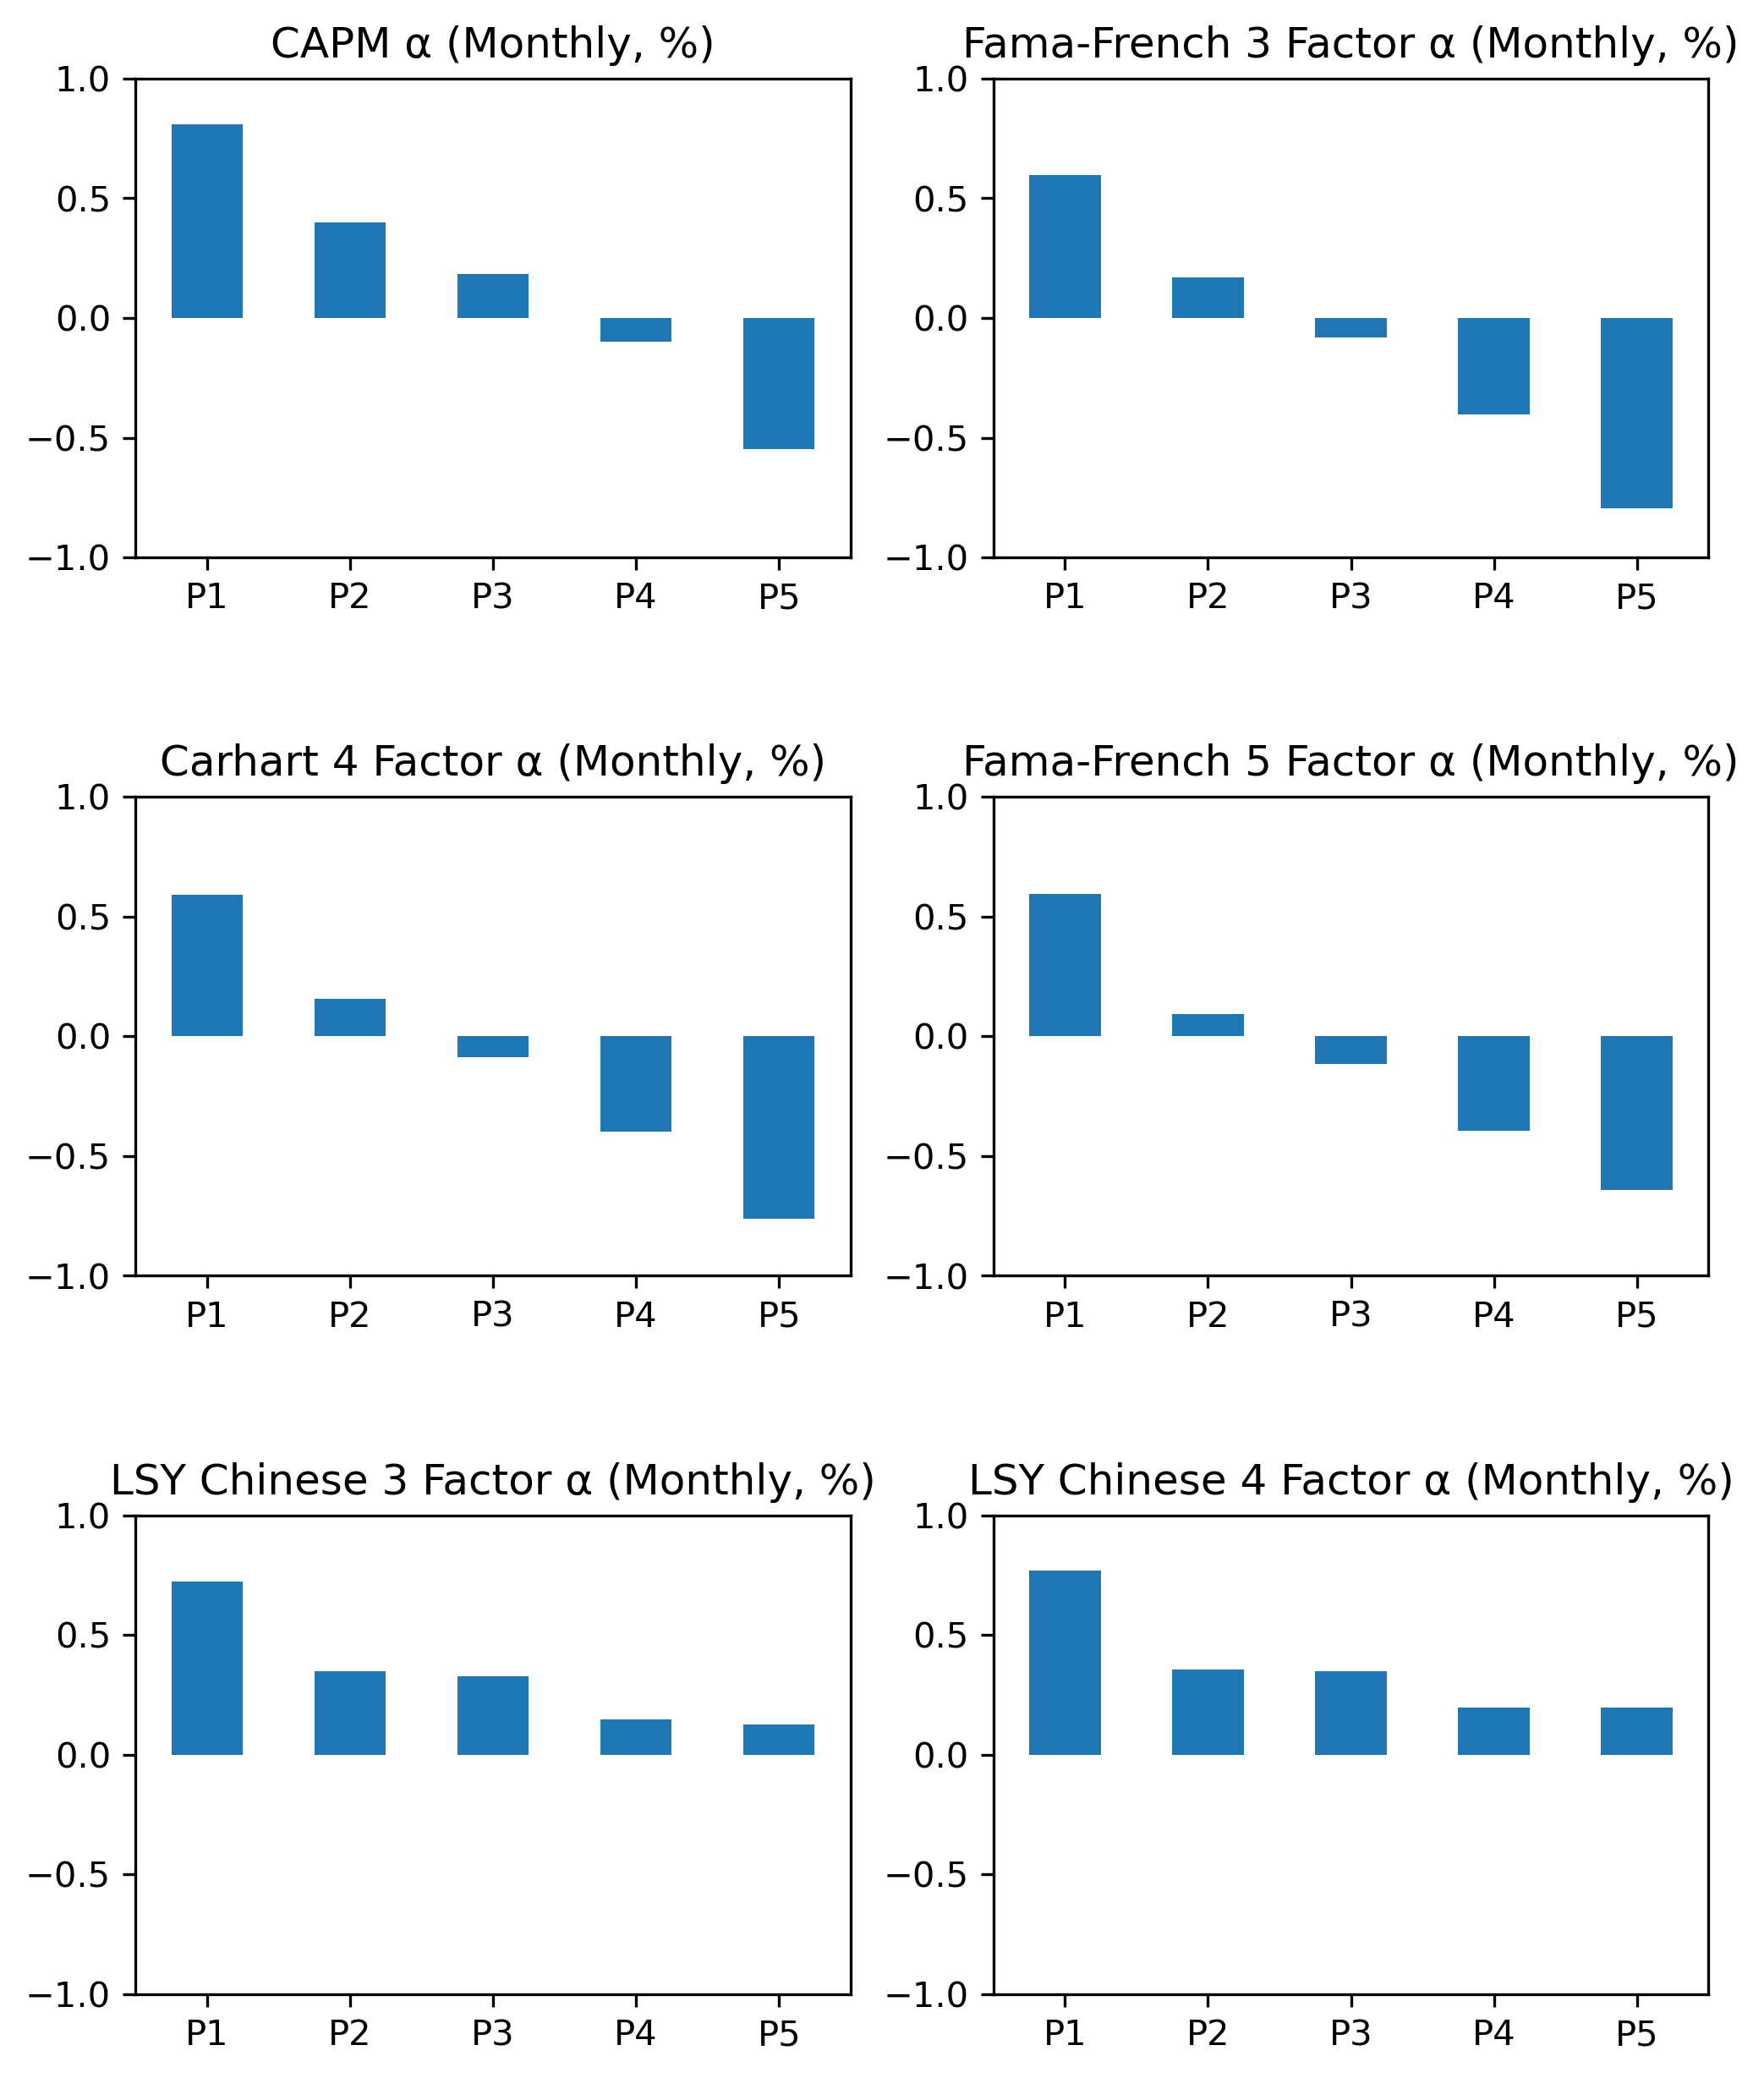

In [6]:
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

fig, axes = plt.subplots(3, 2, figsize=(8,10))
result.T["CAPM_alpha%"].plot.bar(ax=axes[0, 0])
axes[0,0].set_title("CAPM α (Monthly, %)")
axes[0,0].set_xticklabels(["P1","P2","P3","P4","P5"], rotation=0)

result.T["FF3_alpha%"].plot.bar(ax=axes[0, 1])
axes[0,1].set_title("Fama-French 3 Factor α (Monthly, %)")
axes[0,1].set_xticklabels(["P1","P2","P3","P4","P5"], rotation=0)

result.T["Carhart4_alpha%"].plot.bar(ax=axes[1, 0])
axes[1,0].set_title("Carhart 4 Factor α (Monthly, %)")
axes[1,0].set_xticklabels(["P1","P2","P3","P4","P5"], rotation=0)

result.T["FF5_alpha%"].plot.bar(ax=axes[1, 1])
axes[1,1].set_title("Fama-French 5 Factor α (Monthly, %)")
axes[1,1].set_xticklabels(["P1","P2","P3","P4","P5"], rotation=0)

result.T["LSY3_alpha%"].plot.bar(ax=axes[2, 0])
axes[2,0].set_title("LSY Chinese 3 Factor α (Monthly, %)")
axes[2,0].set_xticklabels(["P1","P2","P3","P4","P5"], rotation=0)

result.T["LSY4_alpha%"].plot.bar(ax=axes[2, 1])
axes[2,1].set_title("LSY Chinese 4 Factor α (Monthly, %)")
axes[2,1].set_xticklabels(["P1","P2","P3","P4","P5"], rotation=0)


plt.subplots_adjust(hspace=0.5, wspace=0.2)


# make sure that the range of y axis are the same

for ii in range(3):
    for jj in range(2):
        axes[ii,jj].set_ylim(-1, 1)
        
plt.savefig('result/figure2.jpg')

In [7]:
generate_table(df_return=df_port_TVW, df_mon=df_month, wei='total_value').to_csv("result/table2.csv")
result = generate_table(df_return=df_port_TVW, df_mon=df_month, wei='total_value')
generate_table(df_return=df_port_TVW, df_mon=df_month, wei='total_value')

,port_1,port_2,port_3,port_4,port_5
Excess_Return%,1.219080,1.499706,1.496471,1.121204,1.001006
t-Excess_Return,2.482828,2.391452,2.031142,1.539368,1.166082
CAPM_alpha%,0.764890,0.884662,0.756997,0.391580,0.155345
t-CAPM_alpha,3.591426,4.701778,4.245872,2.222771,0.615948
FF3_alpha%,0.833525,1.055989,0.894683,0.382303,0.082217
t-FF3_alpha,3.867415,5.312813,4.822904,2.451541,0.317726
Carhart4_alpha%,0.831354,1.101978,0.899437,0.403197,0.141601
t-Carhart4_alpha,3.598068,5.484513,4.801813,2.539336,0.515540
FF5_alpha%,0.774604,1.035096,0.884366,0.464584,0.270263
t-FF5_alpha,3.109759,4.606661,4.976033,2.734643,1.042518


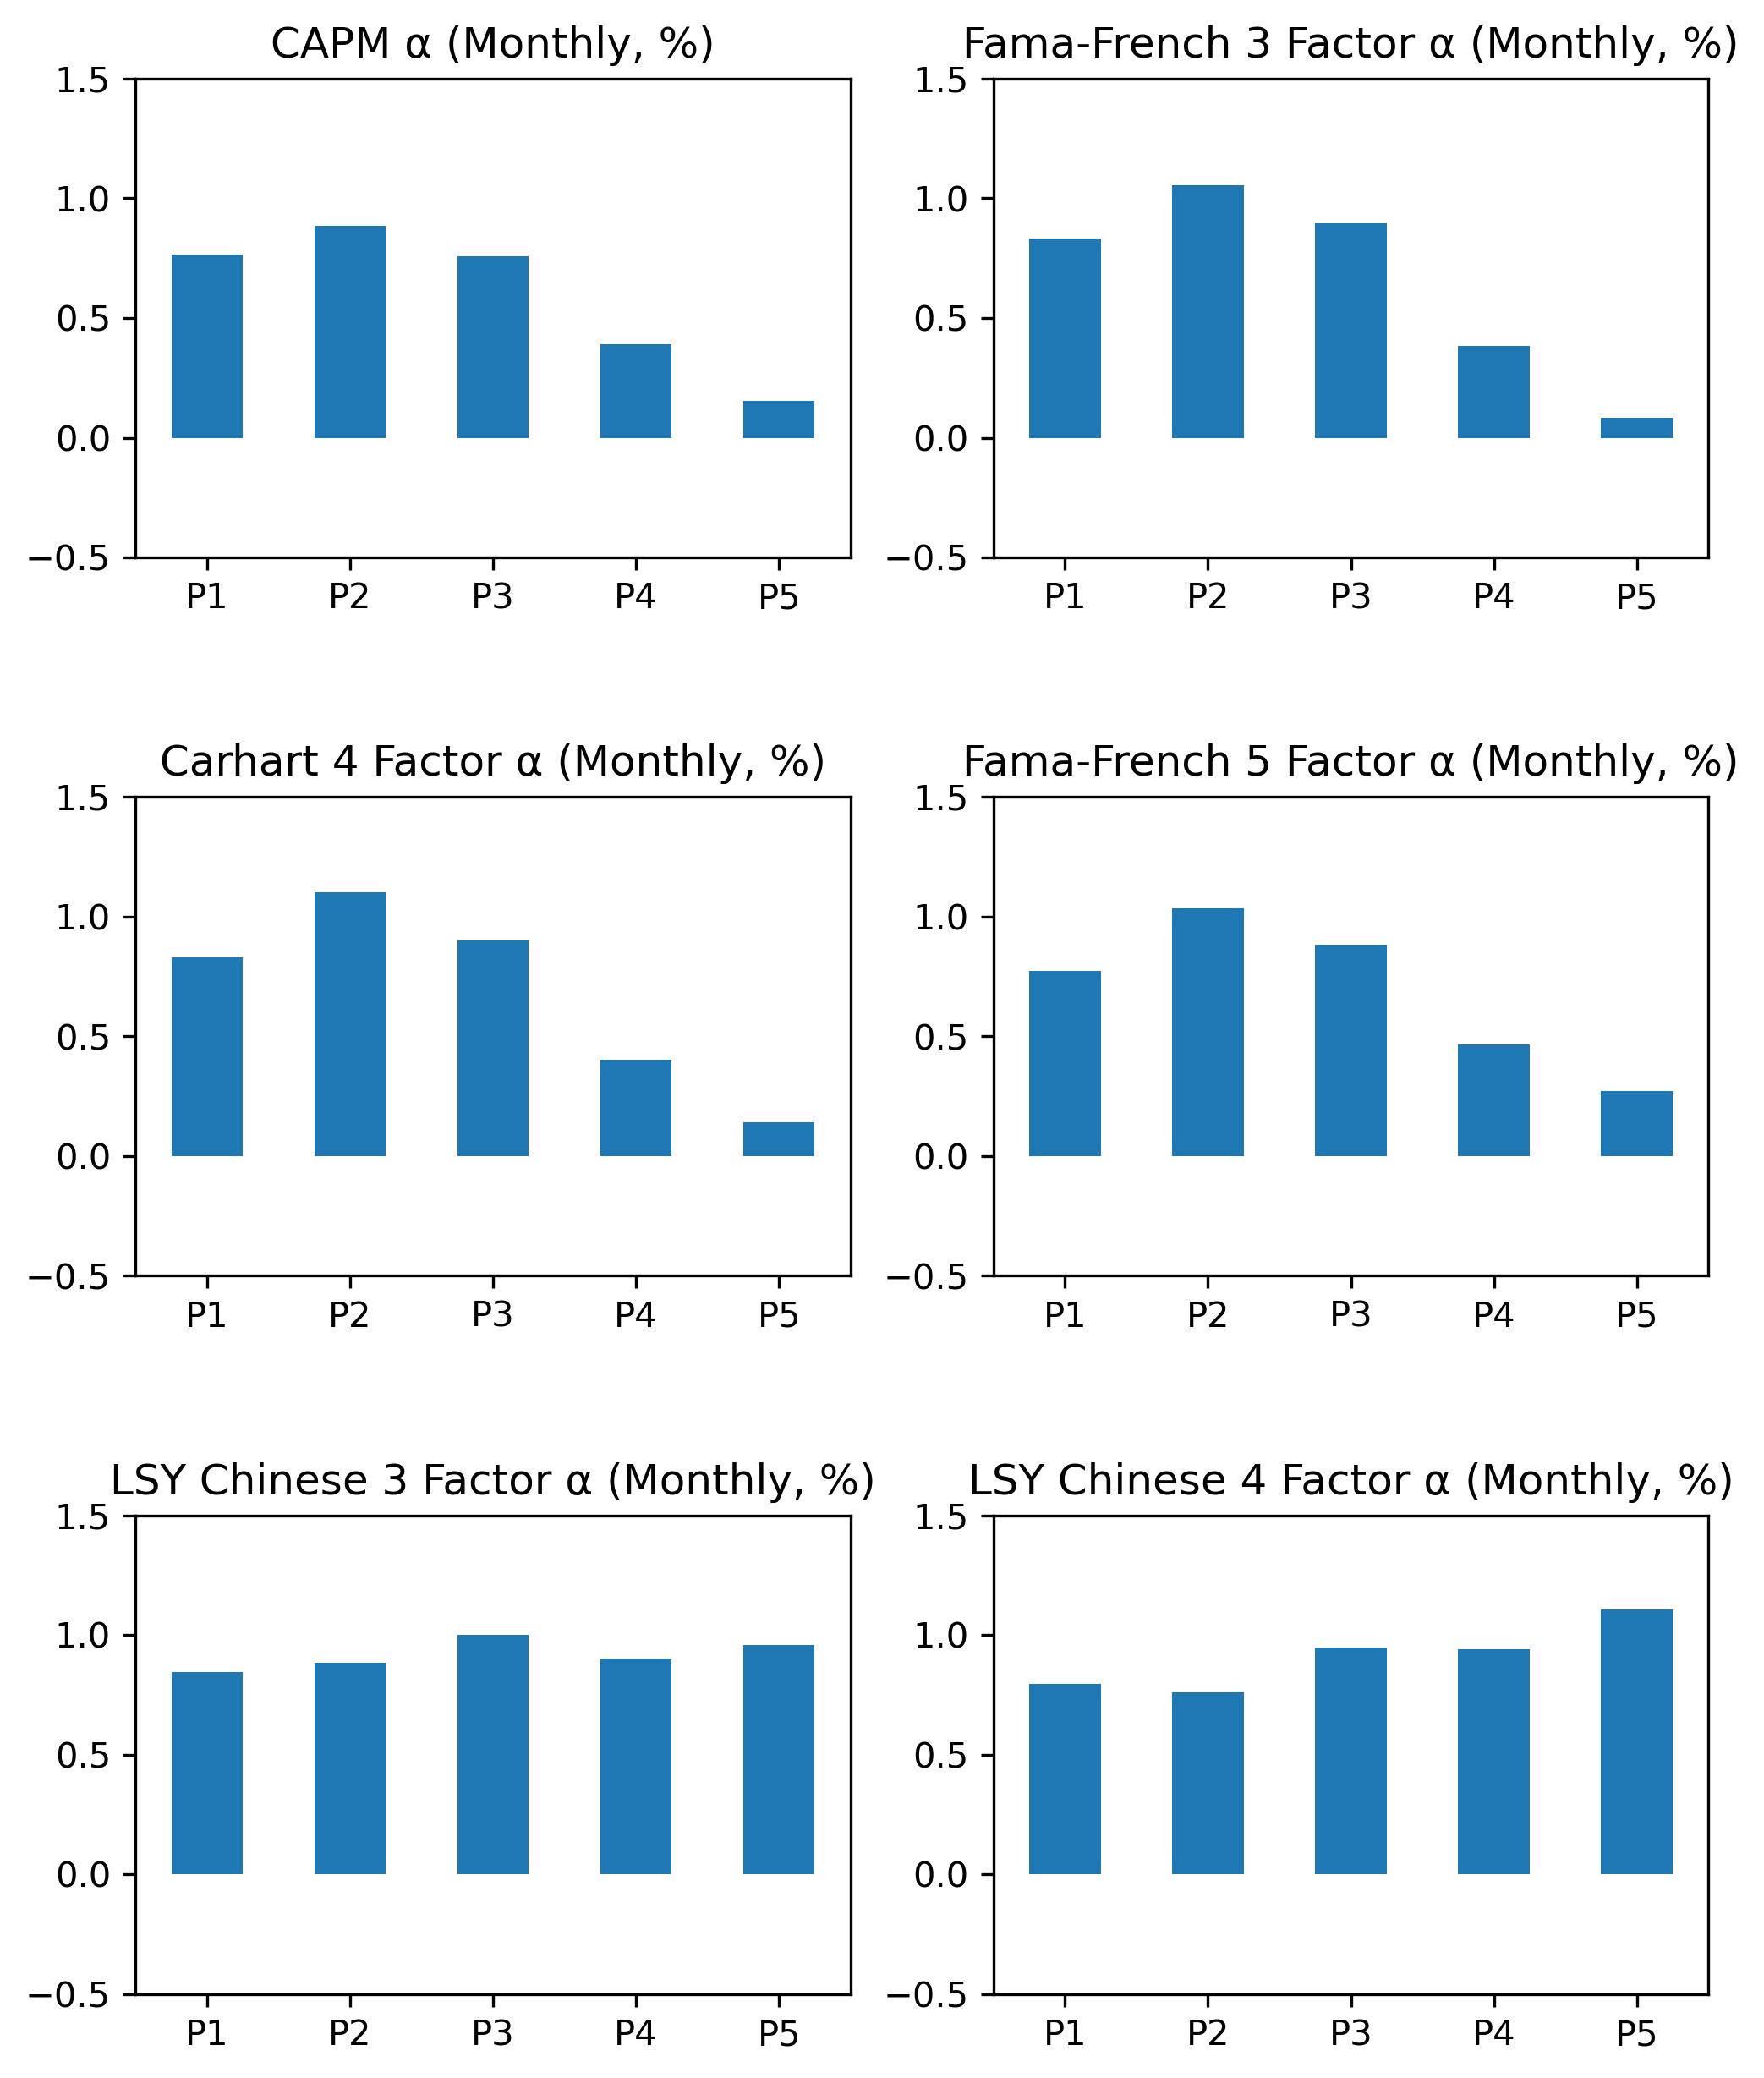

In [8]:
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

fig, axes = plt.subplots(3, 2, figsize=(8,10))
result.T["CAPM_alpha%"].plot.bar(ax=axes[0, 0])
axes[0,0].set_title("CAPM α (Monthly, %)")
axes[0,0].set_xticklabels(["P1","P2","P3","P4","P5"], rotation=0)

result.T["FF3_alpha%"].plot.bar(ax=axes[0, 1])
axes[0,1].set_title("Fama-French 3 Factor α (Monthly, %)")
axes[0,1].set_xticklabels(["P1","P2","P3","P4","P5"], rotation=0)

result.T["Carhart4_alpha%"].plot.bar(ax=axes[1, 0])
axes[1,0].set_title("Carhart 4 Factor α (Monthly, %)")
axes[1,0].set_xticklabels(["P1","P2","P3","P4","P5"], rotation=0)

result.T["FF5_alpha%"].plot.bar(ax=axes[1, 1])
axes[1,1].set_title("Fama-French 5 Factor α (Monthly, %)")
axes[1,1].set_xticklabels(["P1","P2","P3","P4","P5"], rotation=0)

result.T["LSY3_alpha%"].plot.bar(ax=axes[2, 0])
axes[2,0].set_title("LSY Chinese 3 Factor α (Monthly, %)")
axes[2,0].set_xticklabels(["P1","P2","P3","P4","P5"], rotation=0)

result.T["LSY4_alpha%"].plot.bar(ax=axes[2, 1])
axes[2,1].set_title("LSY Chinese 4 Factor α (Monthly, %)")
axes[2,1].set_xticklabels(["P1","P2","P3","P4","P5"], rotation=0)


plt.subplots_adjust(hspace=0.5, wspace=0.2)


# make sure that the range of y axis are the same

for ii in range(3):
    for jj in range(2):
        axes[ii,jj].set_ylim(-0.5, 1.5)
plt.savefig('result/figure4.jpg')        

In [9]:
generate_table(df_return=df_port_CVW, df_mon=df_month, wei='cir_value').to_csv("result/table3.csv")
result = generate_table(df_return=df_port_CVW, df_mon=df_month, wei='cir_value')
generate_table(df_return=df_port_CVW, df_mon=df_month, wei='cir_value')

,port_1,port_2,port_3,port_4,port_5
Excess_Return%,1.497958,1.735313,1.411533,1.322428,0.909872
t-Excess_Return,2.920650,2.675967,1.998013,1.749215,1.052505
CAPM_alpha%,1.002873,1.084748,0.702967,0.564564,0.054390
t-CAPM_alpha,5.711559,6.871618,4.154016,3.044856,0.222754
FF3_alpha%,0.952967,1.082510,0.724391,0.464928,-0.074284
t-FF3_alpha,5.519202,6.515839,4.973790,3.140532,-0.310644
Carhart4_alpha%,0.921687,1.088297,0.721869,0.482604,-0.004467
t-Carhart4_alpha,5.033649,6.555990,4.938651,3.223677,-0.017314
FF5_alpha%,0.956054,1.126911,0.766895,0.594687,0.191565
t-FF5_alpha,5.025476,5.875883,5.062585,3.466328,0.815030


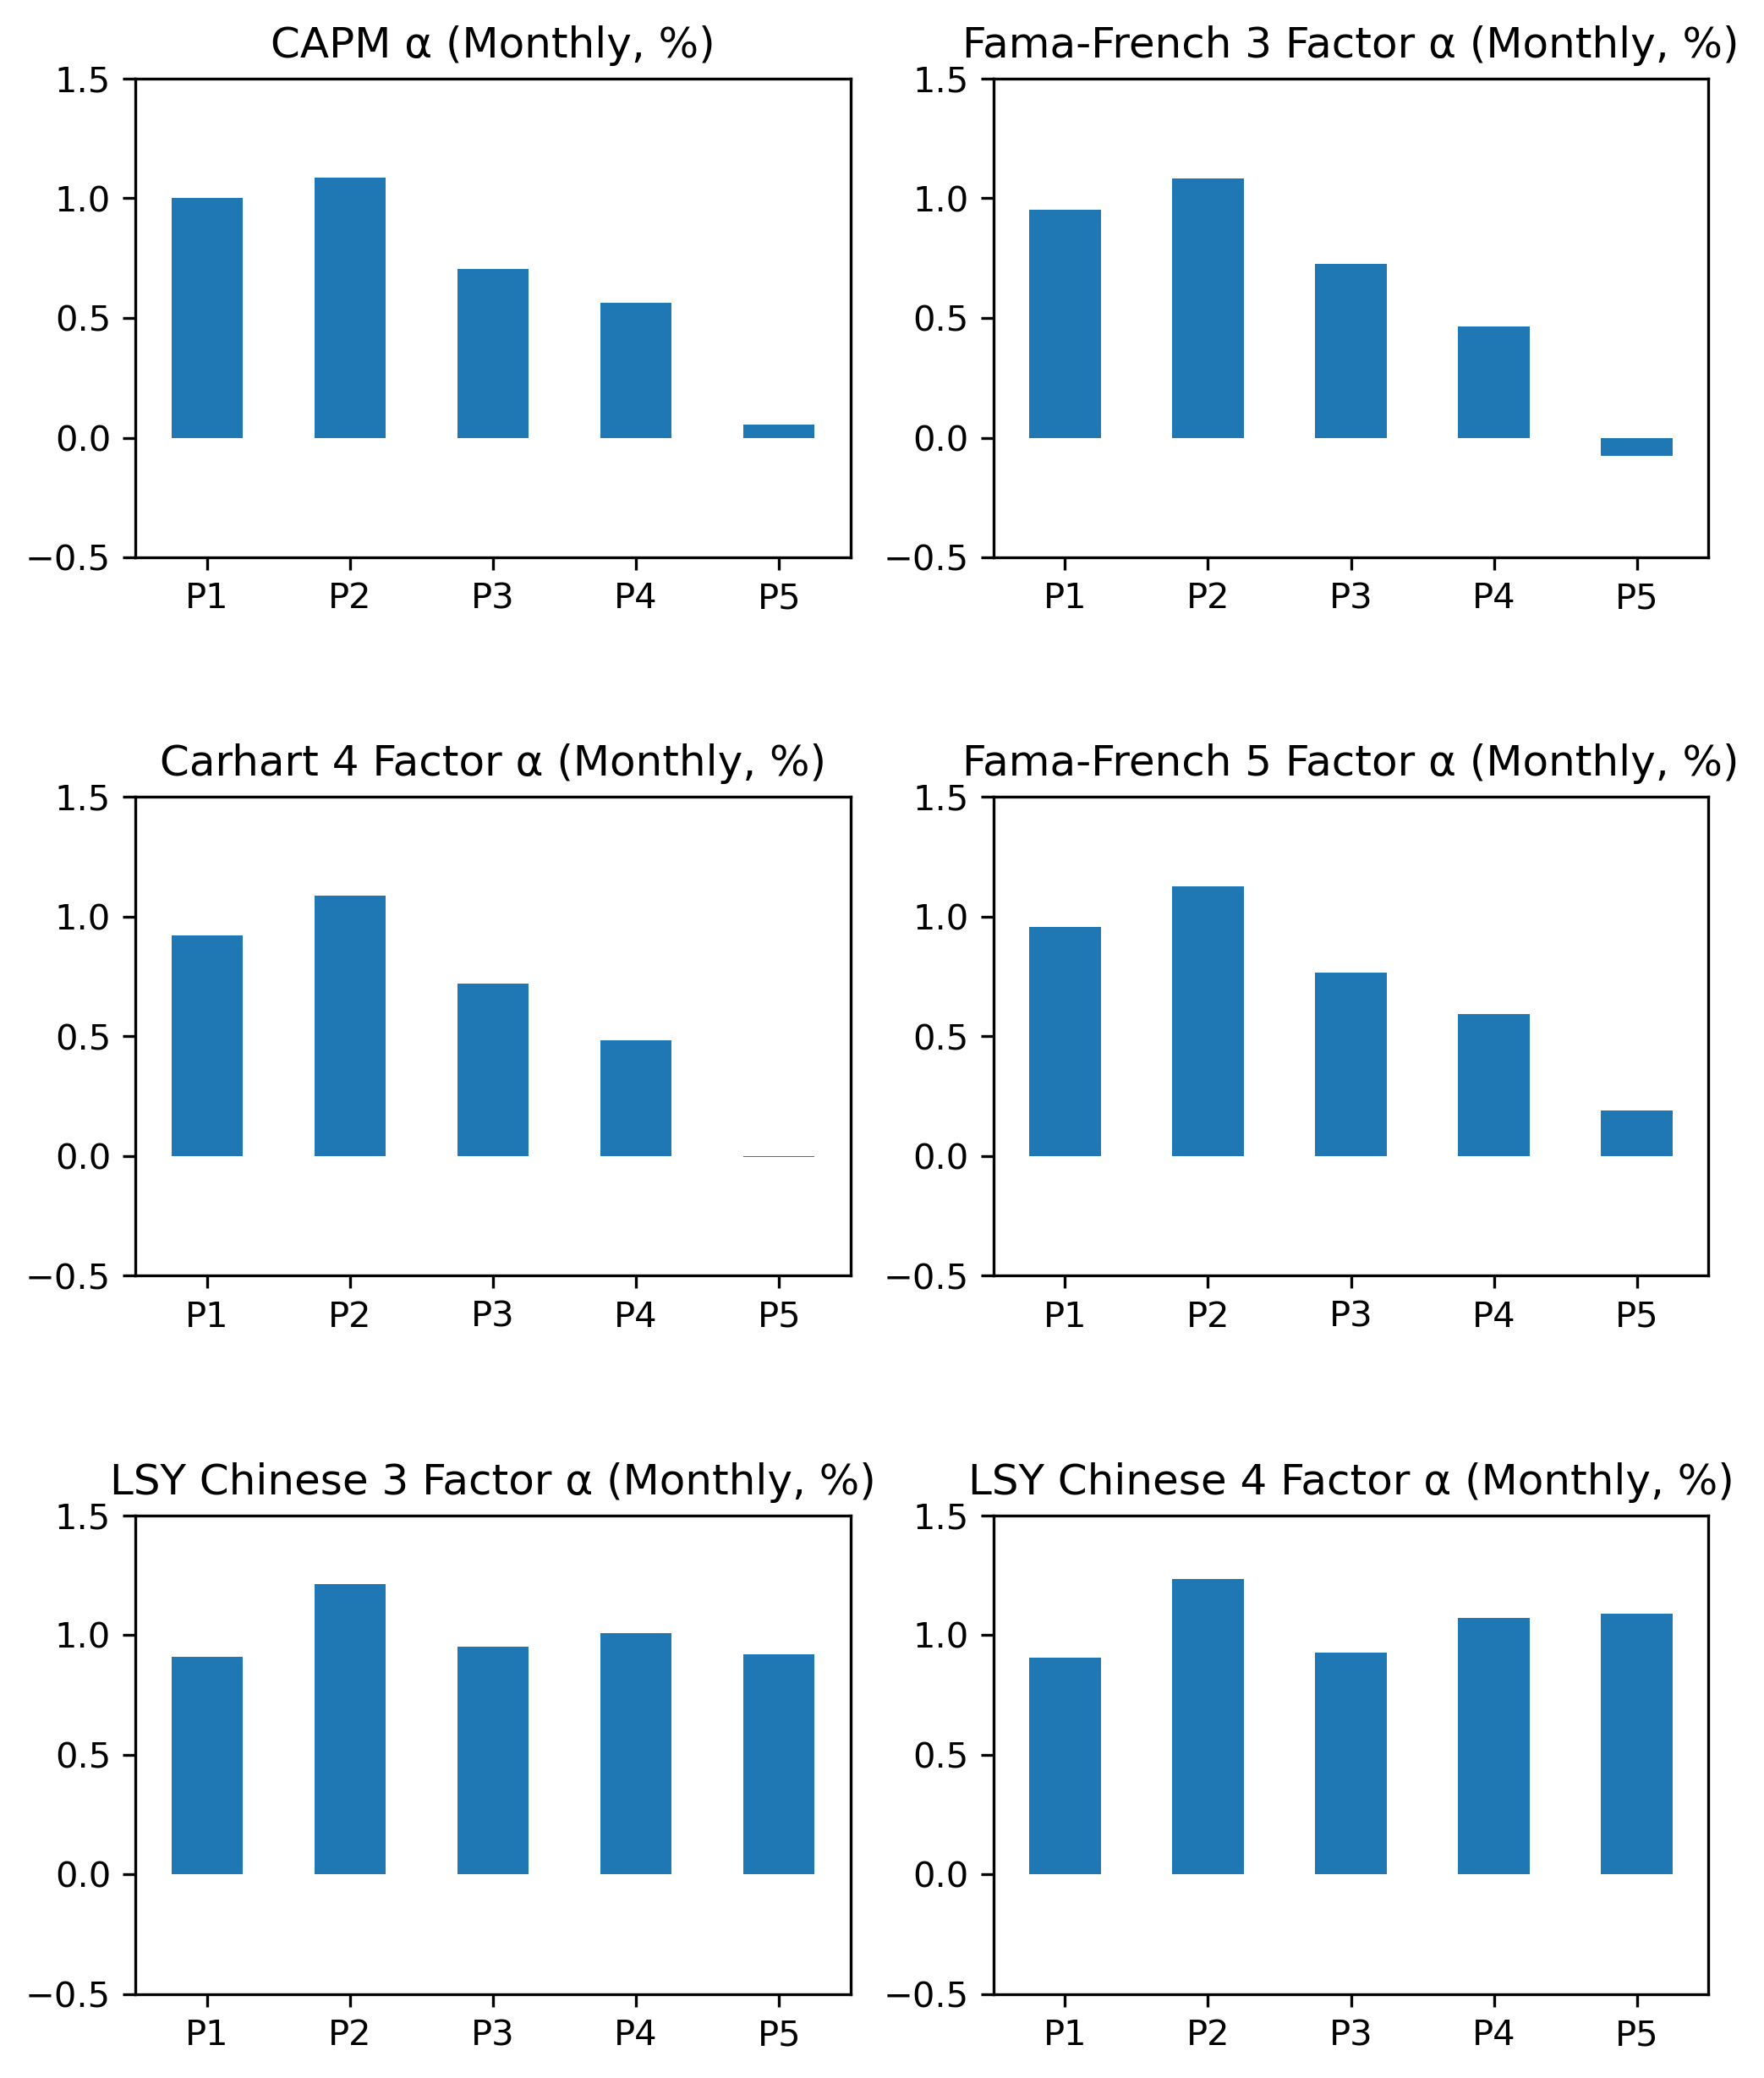

In [10]:
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

fig, axes = plt.subplots(3, 2, figsize=(8,10))
result.T["CAPM_alpha%"].plot.bar(ax=axes[0, 0])
axes[0,0].set_title("CAPM α (Monthly, %)")
axes[0,0].set_xticklabels(["P1","P2","P3","P4","P5"], rotation=0)

result.T["FF3_alpha%"].plot.bar(ax=axes[0, 1])
axes[0,1].set_title("Fama-French 3 Factor α (Monthly, %)")
axes[0,1].set_xticklabels(["P1","P2","P3","P4","P5"], rotation=0)

result.T["Carhart4_alpha%"].plot.bar(ax=axes[1, 0])
axes[1,0].set_title("Carhart 4 Factor α (Monthly, %)")
axes[1,0].set_xticklabels(["P1","P2","P3","P4","P5"], rotation=0)

result.T["FF5_alpha%"].plot.bar(ax=axes[1, 1])
axes[1,1].set_title("Fama-French 5 Factor α (Monthly, %)")
axes[1,1].set_xticklabels(["P1","P2","P3","P4","P5"], rotation=0)

result.T["LSY3_alpha%"].plot.bar(ax=axes[2, 0])
axes[2,0].set_title("LSY Chinese 3 Factor α (Monthly, %)")
axes[2,0].set_xticklabels(["P1","P2","P3","P4","P5"], rotation=0)

result.T["LSY4_alpha%"].plot.bar(ax=axes[2, 1])
axes[2,1].set_title("LSY Chinese 4 Factor α (Monthly, %)")
axes[2,1].set_xticklabels(["P1","P2","P3","P4","P5"], rotation=0)


plt.subplots_adjust(hspace=0.5, wspace=0.2)


# make sure that the range of y axis are the same

for ii in range(3):
    for jj in range(2):
        axes[ii,jj].set_ylim(-0.5, 1.5)
plt.savefig('result/figure6.jpg')        

In [11]:
# First row Excess Return
def excess_return(df_return):
    """
    Calculate the first row "Excess Return" and their pvalue
    for Portfolio 1, Portfolio 2,..., Portfolio 5
    """
    df = df_return.set_index("date")
    df_result = pd.DataFrame()
    for i in range(1,6):
        df0 = df[df['decile']==i]
        
        y = df0['excess_return']
        x = df0.drop(["decile","excess_return"], axis=1)
        x = sm.add_constant(x)
        results = sm.OLS(y, x).fit(cov_type='HC1')
        
        par0 = pd.Series([results.params[0], results.pvalues[0]])
        par0.name= 'port_{}'.format(i)
        df_result = df_result.append(par0)
        
    df_result.columns = ["Excess_Return%","p-Excess_Return"]
    df_result["Excess_Return%"] = 100 * df_result["Excess_Return%"]
    return df_result.T

# 2nd to 5th row: alpha
def factor_alpha(df_return, df_factor):
    """
    Calculate the 2nd to 5th row "alpha" and their palue
    for Portfolio 1, Portfolio 2,..., Portfolio 5
    """
    df_factor["date"] = pd.to_datetime(df_factor["date"], format="%Y-%m-%d")
    df = pd.merge(df_return, df_factor, on="date", how="left")
    df = df.set_index("date")

    df_result = pd.DataFrame()
    for i in range(1,6):
        df0 = df[df['decile']==i]
        
        y = df0['excess_return']
        x = df0.drop(["decile","excess_return","RF"], axis=1)
        x = sm.add_constant(x)
        results = sm.OLS(y, x).fit(cov_type='HC1')
        
      
        par0 = pd.Series([results.params[0], results.pvalues[0]])
        par0.name= 'port_{}'.format(i)
        df_result = df_result.append(par0)
        
    df_result.columns = ["alpha%","p-alpha"]
    df_result["alpha%"] = 100 * df_result["alpha%"]
    return df_result.T

# row 6 "beta (ex ante)" 
def beta_ante(df_3_month, weight='equal'):
    """
    Calculate the 6th row "beta (ex ante)" 
    for Portfolio 1, Portfolio 2,..., Portfolio 5
    """
    if weight == 'equal':
        df_beta_ante = pd.DataFrame(df_3_month.groupby("decile")["beta"].mean()).T
        
    elif weight == 'total_value':
        f = lambda subdf: ((subdf["beta"]*subdf["s_val_mv"]).sum()) / (subdf["s_val_mv"].sum())
        df_beta_ante = pd.DataFrame(df_3_month
                                    .groupby("decile")
                                    [["beta", "s_val_mv"]]
                                    .apply(f)
                                   ).T
        
    elif weight == 'cir_value':
        f = lambda subdf: ((subdf["beta"]*subdf["s_dq_mv"]).sum()) / (subdf["s_dq_mv"].sum())
        df_beta_ante = pd.DataFrame(df_3_month
                                    .groupby("decile")
                                    [["beta", "s_dq_mv"]]
                                    .apply(f)
                                   ).T
        
    df_beta_ante.columns = ["port_1", "port_2", "port_3", "port_4", "port_5"]
    df_beta_ante.index = ["beta (ex ante)"]                   
    return df_beta_ante

# row7: beta (realized) and volatility%
def beta_volatility(df_return, df_factor):
    """
    Calculate the 6th row:  beta (realized)	and
    the 7th row volatility%
    for Portfolio 1, Portfolio 2,..., Portfolio 6
    """
    df_factor["date"] = pd.to_datetime(df_factor["date"], format="%Y-%m-%d")
    df = pd.merge(df_return, df_factor, on="date", how="left")
    df = df.set_index("date")

    df_result = pd.DataFrame()
    for i in range(1,6):
        df0 = df[df['decile']==i]
        
        y = df0['excess_return']
        x = df0['MKT']
        x = sm.add_constant(x)
        results = sm.OLS(y, x).fit(cov_type='HC1')
        
        volatility = y.std()
        par0 = pd.Series([results.params[1], volatility])
        par0.name= 'port_{}'.format(i)
        df_result = df_result.append(par0)
        
    df_result.columns = ["beta (realized)", "volatility%"]
    df_result["volatility%"] = df_result["volatility%"]*100*np.sqrt(12)
    # convert the volatility to percentage annualized
    return df_result.T

def generate_table(df_return, df_mon=df_month, wei='equal'):
    """
    Use all the function above to form table
    """
    table3_row1 = excess_return(df_return)
    
    df_capm = pd.read_csv("Data/Factor/ChineseCAPM_Classical_Month.csv")
    table3_row2 = factor_alpha(df_return, df_capm)
    table3_row2.index = ["CAPM_alpha%" , "p-CAPM_alpha"]
    
    df_FF3 = pd.read_csv("Data/Factor/ChineseFF3_Classical_Month.csv")
    table3_row3 = factor_alpha(df_return, df_FF3)
    table3_row3.index = ["FF3_alpha%" , "p-FF3_alpha"]
    
    df_Carhart4 = pd.read_csv("Data/Factor/ChineseCarhart4_Classical_Month.csv")
    table3_row4 = factor_alpha(df_return, df_Carhart4)
    table3_row4.index = ["Carhart4_alpha%" , "p-Carhart4_alpha"]
    
    df_FF5 = pd.read_csv("Data/Factor/ChineseFF5_Classical_Month.csv")
    table3_row5 = factor_alpha(df_return, df_FF5)
    table3_row5.index = ["FF5_alpha%" , "p-FF5_alpha"]
    
    df_LSY3 = (pd.read_csv("Data/Factor/CH_3_update_20201231.csv",header=8)
           .rename({"mnthdt":"date","rf_mon":"RF"}, axis=1))
    df_LSY3["date"] =  pd.to_datetime(df_LSY3["date"], format="%Y%m%d").astype("str")
    df_LSY3[["RF", "mktrf", "SMB", "VMG"]] = df_LSY3[["RF", "mktrf", "SMB", "VMG"]]/100
    table3_row9 = factor_alpha(df_return, df_LSY3)
    table3_row9.index = ["LSY3_alpha%" , "p-LSY3_alpha"]
    
    df_LSY4 = (pd.read_csv("Data/Factor/CH_4_fac_update_20201231.csv",header=9)
               .rename({"mnthdt":"date", "rf_mon":"RF"}, axis=1))
    df_LSY4[["RF","mktrf","VMG","SMB","PMO"]] = df_LSY4[["RF","mktrf","VMG","SMB","PMO"]]/100
    df_LSY4["date"] =  pd.to_datetime(df_LSY4["date"], format="%Y%m%d").astype("str")
    table3_row10 = factor_alpha(df_return, df_LSY4)
    table3_row10.index = ["LSY4_alpha%" , "p-LSY4_alpha"]
    
    table3_row6 = beta_ante(df_mon, weight=wei)
    
    table3_row7 = beta_volatility(df_return, df_factor=df_capm)
    
    table3_row8 = (pd.DataFrame((table3_row1.T["Excess_Return%"]*12) / (table3_row7.T["volatility%"]))
                   .rename({0:"Sharpe Ratio"}, axis=1)
                   .T)
    
    return pd.concat([table3_row1,
                      table3_row2,
                      table3_row3, 
                      table3_row4,
                      table3_row5,
                      table3_row9,
                      table3_row10,
                      table3_row6,
                      table3_row7,
                      table3_row8])

In [12]:
generate_table(df_return=df_port_EW, df_mon=df_month, wei='equal').to_csv("result/table1_pvalue.csv")
generate_table(df_return=df_port_EW, df_mon=df_month, wei='equal')


,port_1,port_2,port_3,port_4,port_5
Excess_Return%,1.366431,1.023472,0.871286,0.622199,2.449068e-01
p-Excess_Return,0.029746,0.131764,0.238042,0.422925,7.704018e-01
CAPM_alpha%,0.808183,0.399031,0.184762,-0.098850,-5.461618e-01
p-CAPM_alpha,0.009690,0.183996,0.554283,0.763004,9.811339e-02
FF3_alpha%,0.595809,0.169939,-0.080267,-0.403139,-7.940092e-01
p-FF3_alpha,0.001529,0.098072,0.425996,0.000113,8.864434e-07
Carhart4_alpha%,0.591569,0.155762,-0.085750,-0.397276,-7.621573e-01
p-Carhart4_alpha,0.002195,0.142058,0.408865,0.000231,8.275909e-06
FF5_alpha%,0.595884,0.093530,-0.114090,-0.393035,-6.421147e-01
p-FF5_alpha,0.002454,0.395040,0.222633,0.000025,3.869806e-05


In [13]:
generate_table(df_return=df_port_TVW, df_mon=df_month, wei='total_value').to_csv("result/table2_pvalue.csv")
generate_table(df_return=df_port_TVW, df_mon=df_month, wei='total_value')

,port_1,port_2,port_3,port_4,port_5
Excess_Return%,1.219080,1.499706e+00,1.496471e+00,1.121204,1.001006
p-Excess_Return,0.013034,1.678187e-02,4.224062e-02,0.123714,0.243581
CAPM_alpha%,0.764890,8.846622e-01,7.569968e-01,0.391580,0.155345
p-CAPM_alpha,0.000329,2.579061e-06,2.177445e-05,0.026231,0.537929
FF3_alpha%,0.833525,1.055989e+00,8.946828e-01,0.382303,0.082217
p-FF3_alpha,0.000110,1.079456e-07,1.414833e-06,0.014225,0.750692
Carhart4_alpha%,0.831354,1.101978e+00,8.994373e-01,0.403197,0.141601
p-Carhart4_alpha,0.000321,4.146098e-08,1.572354e-06,0.011106,0.606176
FF5_alpha%,0.774604,1.035096e+00,8.843665e-01,0.464584,0.270263
p-FF5_alpha,0.001872,4.091870e-06,6.490072e-07,0.006245,0.297172


In [14]:
generate_table(df_return=df_port_CVW, df_mon=df_month, wei='cir_value').to_csv("result/table3_pvalue.csv")
generate_table(df_return=df_port_CVW, df_mon=df_month, wei='cir_value')

,port_1,port_2,port_3,port_4,port_5
Excess_Return%,1.497958e+00,1.735313e+00,1.411533e+00,1.322428e+00,0.909872
p-Excess_Return,3.493017e-03,7.451405e-03,4.571530e-02,8.025388e-02,0.292568
CAPM_alpha%,1.002873e+00,1.084748e+00,7.029665e-01,5.645637e-01,0.054390
p-CAPM_alpha,1.119459e-08,6.347783e-12,3.266900e-05,2.327920e-03,0.823727
FF3_alpha%,9.529668e-01,1.082510e+00,7.243909e-01,4.649278e-01,-0.074284
p-FF3_alpha,3.405423e-08,7.228465e-11,6.565656e-07,1.686416e-03,0.756071
Carhart4_alpha%,9.216866e-01,1.088297e+00,7.218694e-01,4.826043e-01,-0.004467
p-Carhart4_alpha,4.812292e-07,5.527381e-11,7.866470e-07,1.265563e-03,0.986186
FF5_alpha%,9.560544e-01,1.126911e+00,7.668955e-01,5.946866e-01,0.191565
p-FF5_alpha,5.021854e-07,4.205941e-09,4.136103e-07,5.276198e-04,0.415055


# Cumulated Return: Figure 3, 5, 7

In [15]:
df_LSY3 = (pd.read_csv("Data/Factor/CH_3_update_20201231.csv",header=8)
       .rename({"mnthdt":"date","rf_mon":"RF"}, axis=1))
df_LSY3["date"] =  pd.to_datetime(df_LSY3["date"], format="%Y%m%d")
df_LSY3[["RF", "mktrf", "SMB", "VMG"]] = df_LSY3[["RF", "mktrf", "SMB", "VMG"]]/100
df_LSY3 = df_LSY3[["date", "RF", "mktrf"]]

In [16]:
def gen_cum_return(df, df_mktrf=df_LSY3):
    """
    Calculated the cumulated return if 1 yuan was invested in 2001.01.01
    """

    df = pd.merge(df, df_mktrf, how='left', on='date')
    
    # The return of each portfolio is the excess return + risk free return
    # Both return are represented as montly return
    df["return"] = df["excess_return"] + df["RF"]
    df = df[["date", "decile", "return"]]
    df = df[df['date']>"2001-01-01"]
    df = (df.pivot(index="date", columns="decile", values="return")
            .apply(lambda column: (column+1).cumprod()*100, axis=0))
    return df

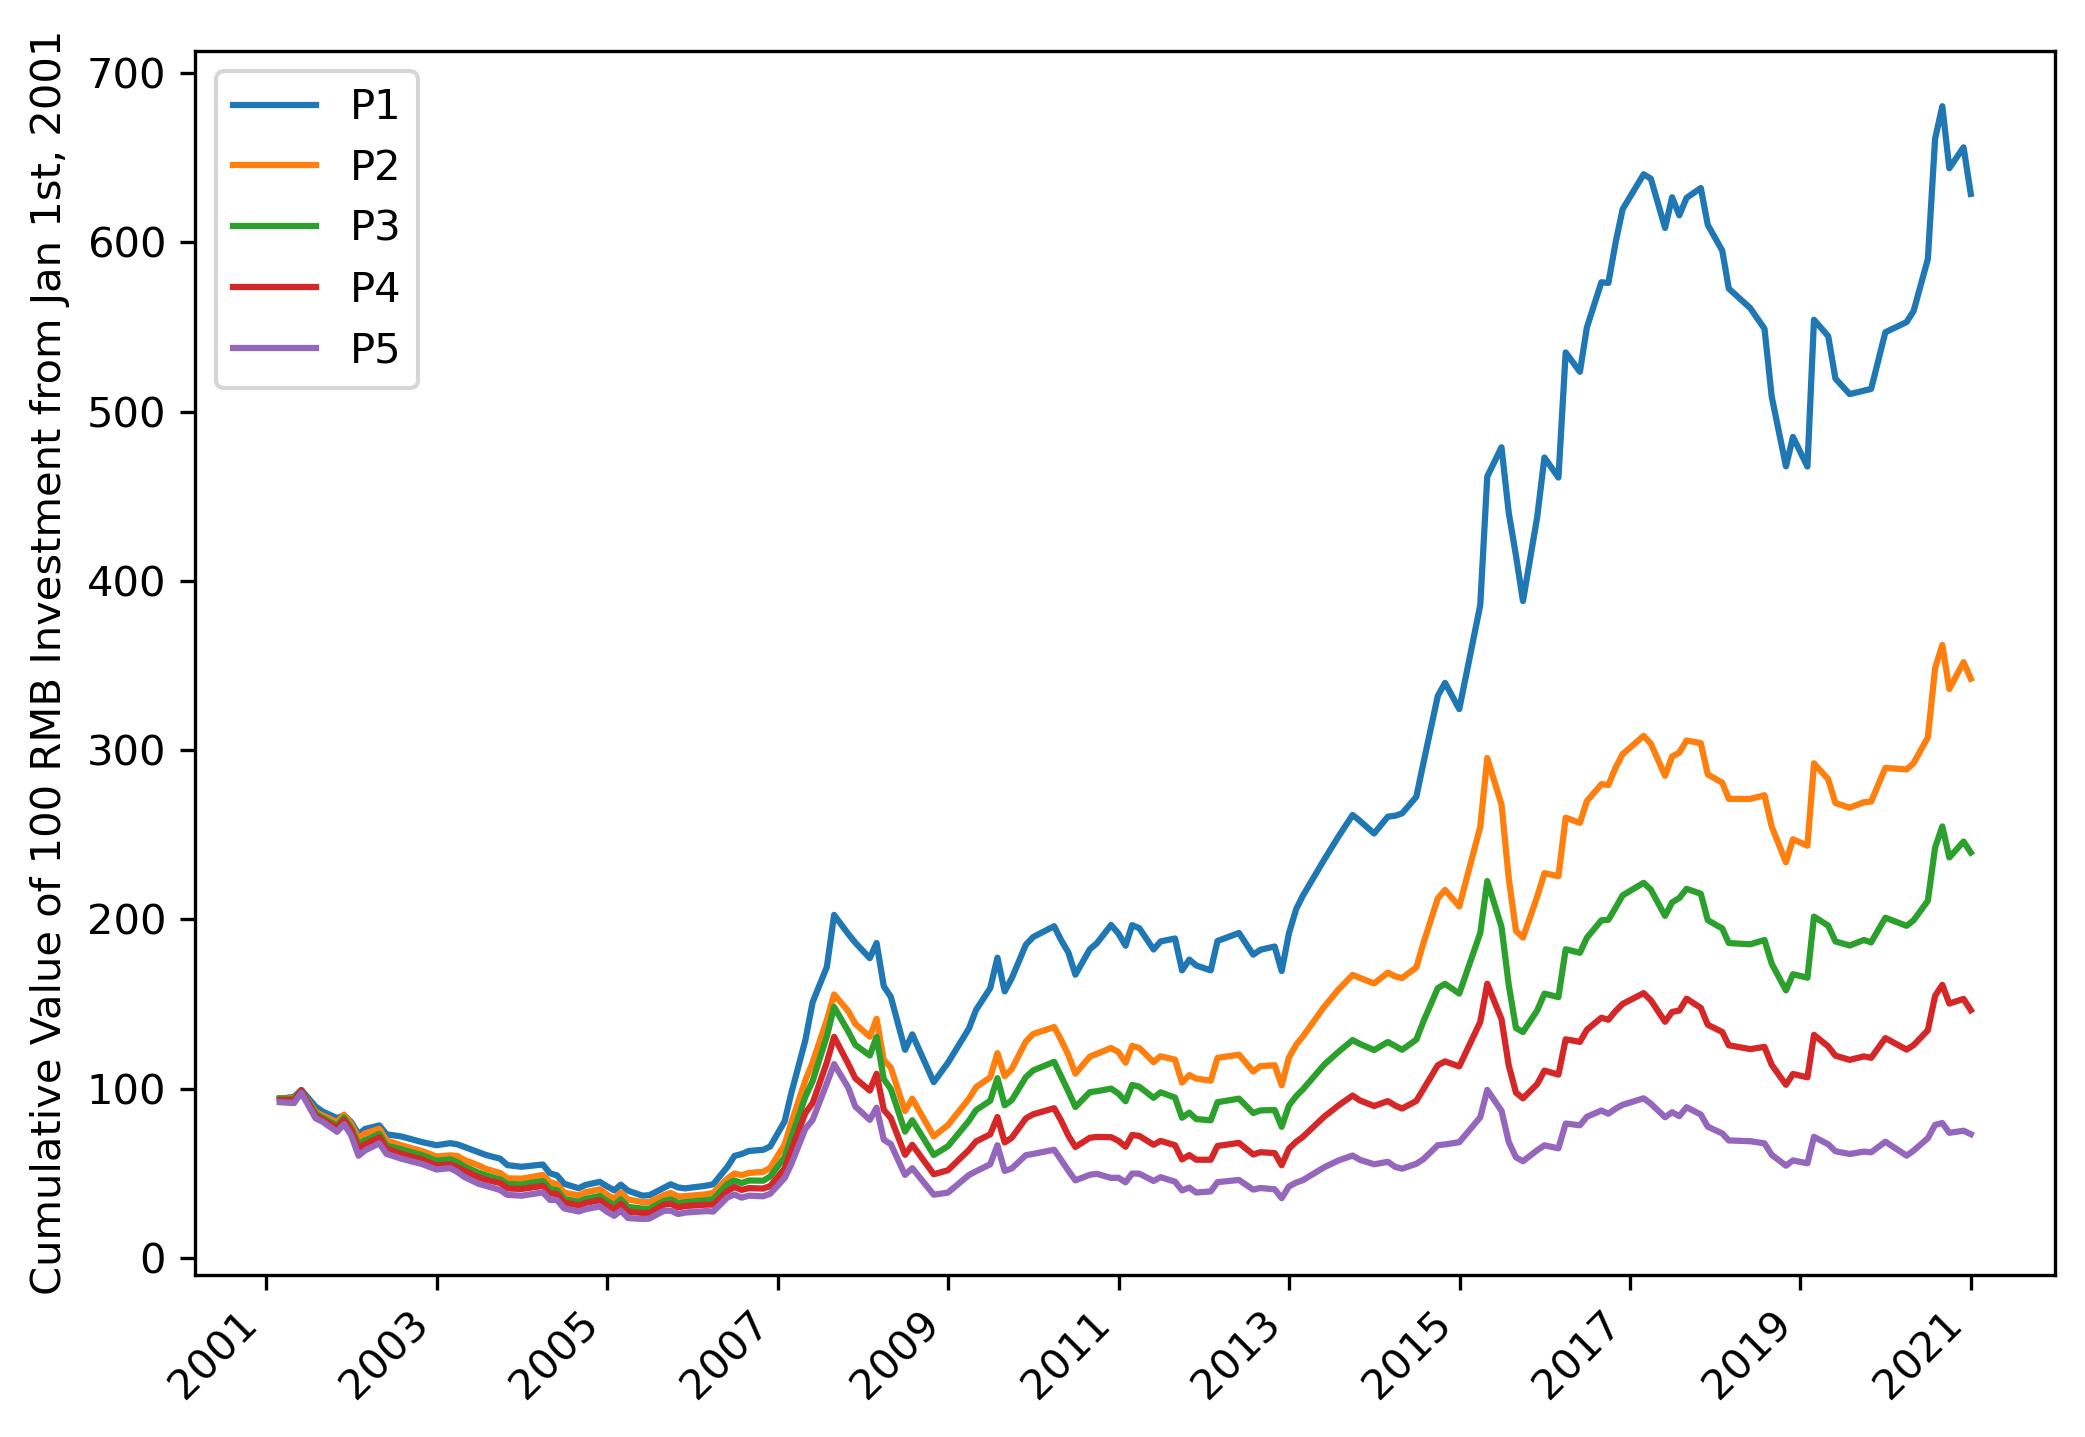

In [17]:
gen_cum_return(df_port_EW).plot(figsize=(8,6))
tic = ['2001-01-01','2003-01-01', '2005-01-01', '2007-01-01',
'2009-01-01','2011-01-01', '2013-01-01', '2015-01-01',
'2017-01-01','2019-01-01','2021-01-01']
lab = ['2001','2003', '2005', '2007',
'2009','2011', '2013', '2015',
'2017','2019','2021']
plt.xticks(ticks=tic, labels=lab, rotation=45, fontsize=10)
plt.ylabel("Cumulative Value of 100 RMB Investment from Jan 1st, 2001", fontsize=10)
plt.xlabel("", fontsize=10) 
plt.legend(["P1", "P2", "P3", "P4", "P5" ])

plt.savefig('result/figure3.jpg') 

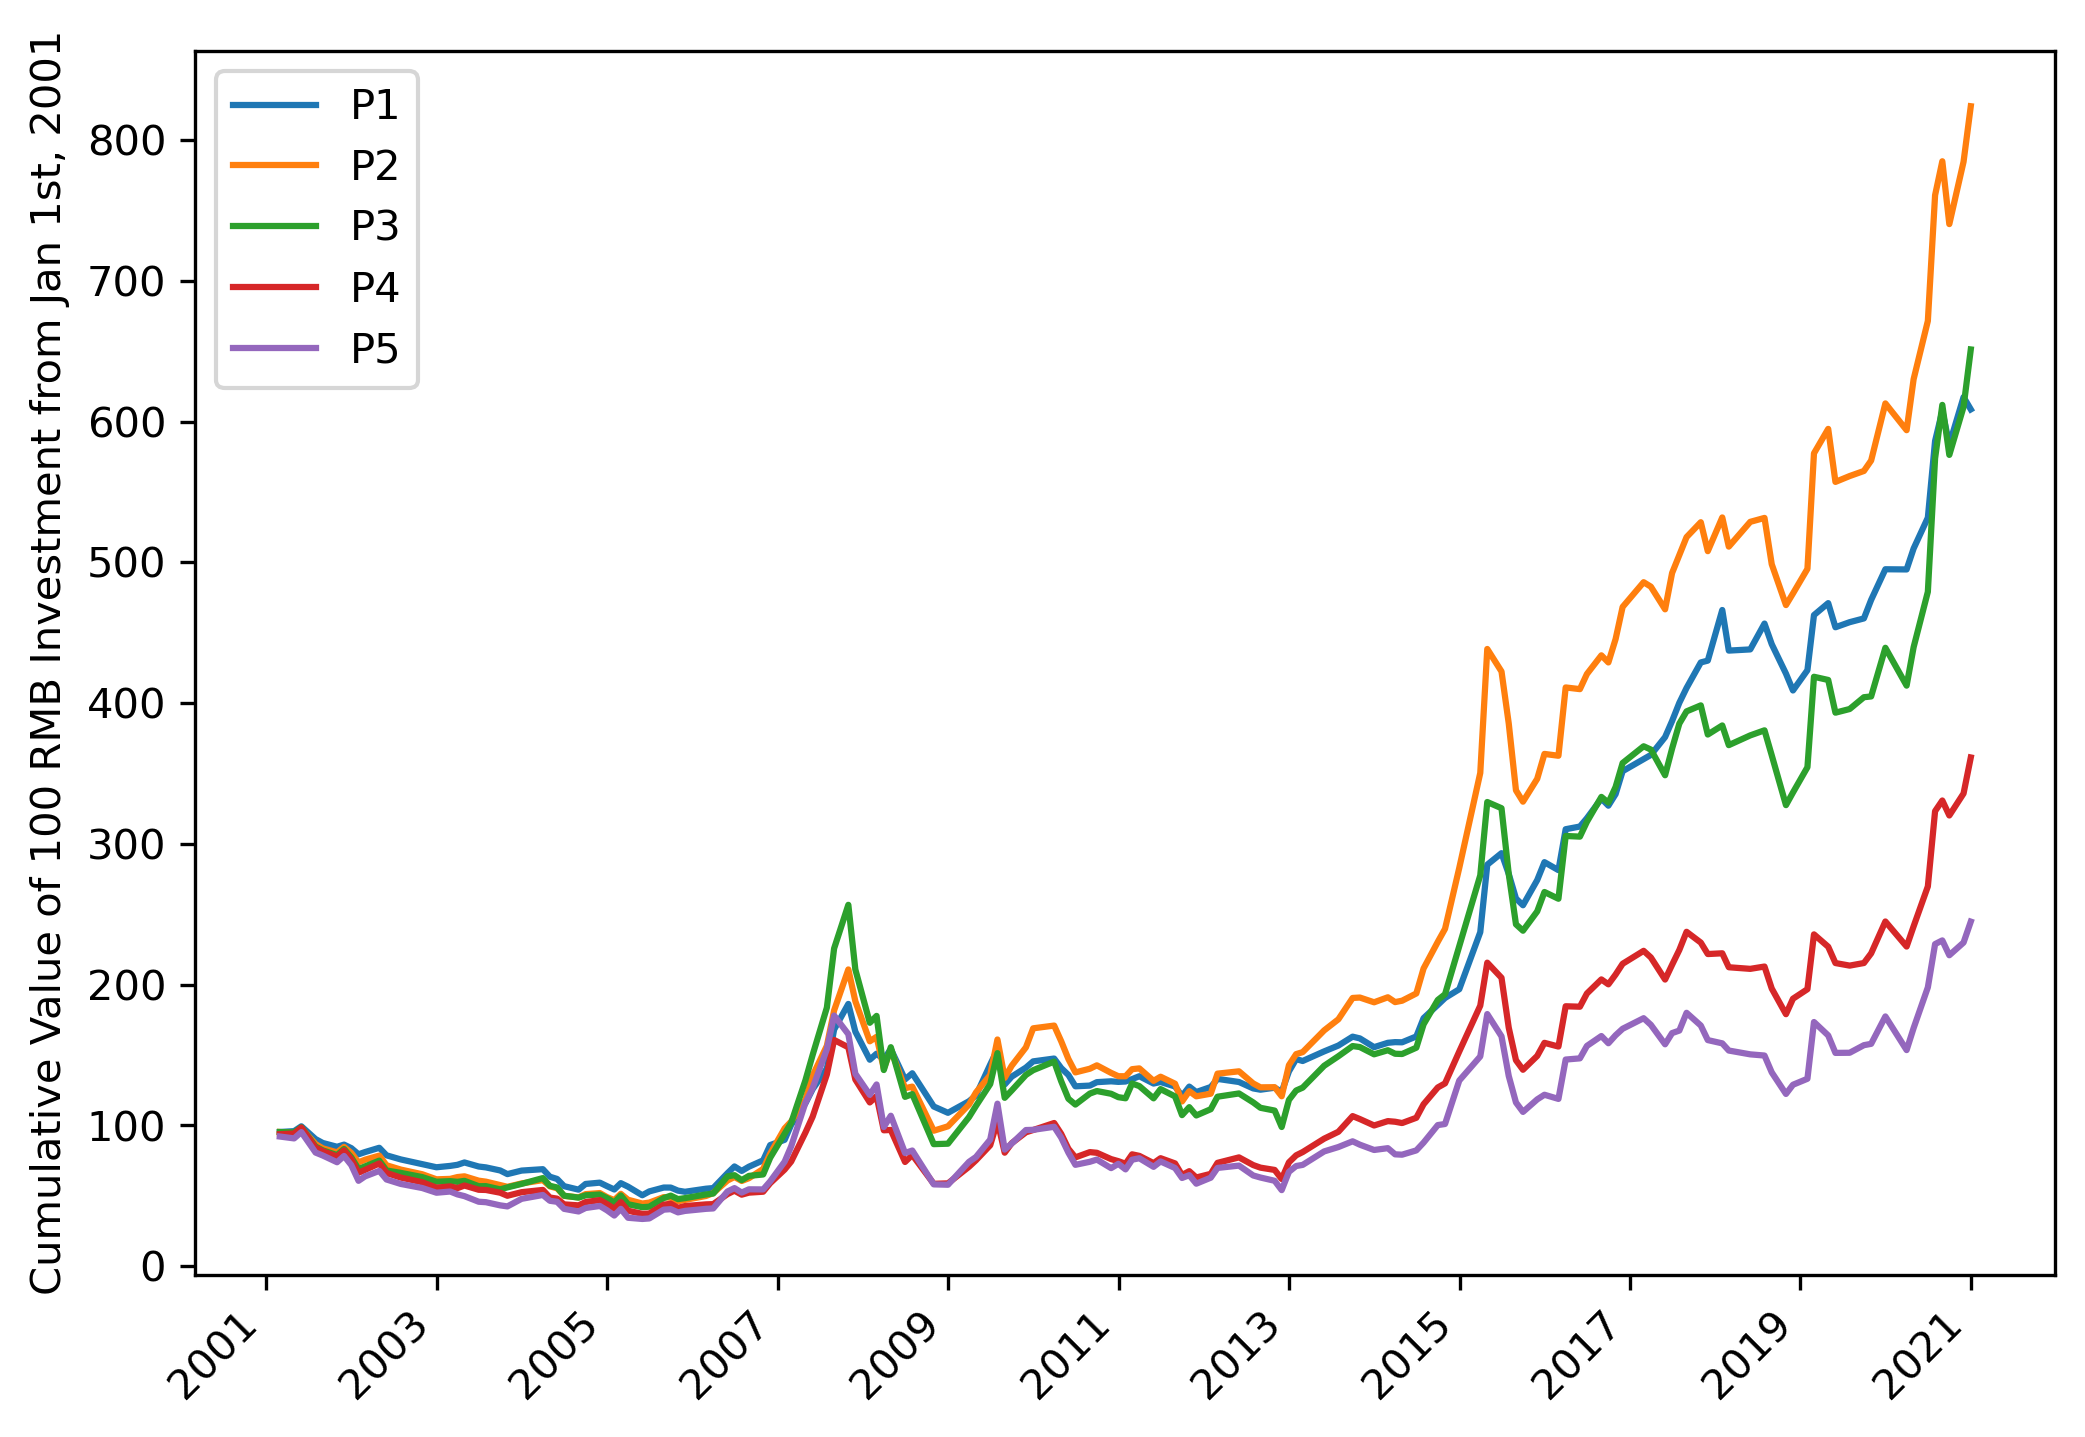

In [18]:
gen_cum_return(df_port_TVW).plot(figsize=(8,6))
tic = ['2001-01-01','2003-01-01', '2005-01-01', '2007-01-01',
'2009-01-01','2011-01-01', '2013-01-01', '2015-01-01',
'2017-01-01','2019-01-01','2021-01-01']
lab = ['2001','2003', '2005', '2007',
'2009','2011', '2013', '2015',
'2017','2019','2021']
plt.xticks(ticks=tic, labels=lab, rotation=45, fontsize=10)
plt.ylabel("Cumulative Value of 100 RMB Investment from Jan 1st, 2001", fontsize=10)
plt.xlabel("", fontsize=10) 
plt.legend(["P1", "P2", "P3", "P4", "P5" ])
plt.savefig('result/figure5.jpg') 

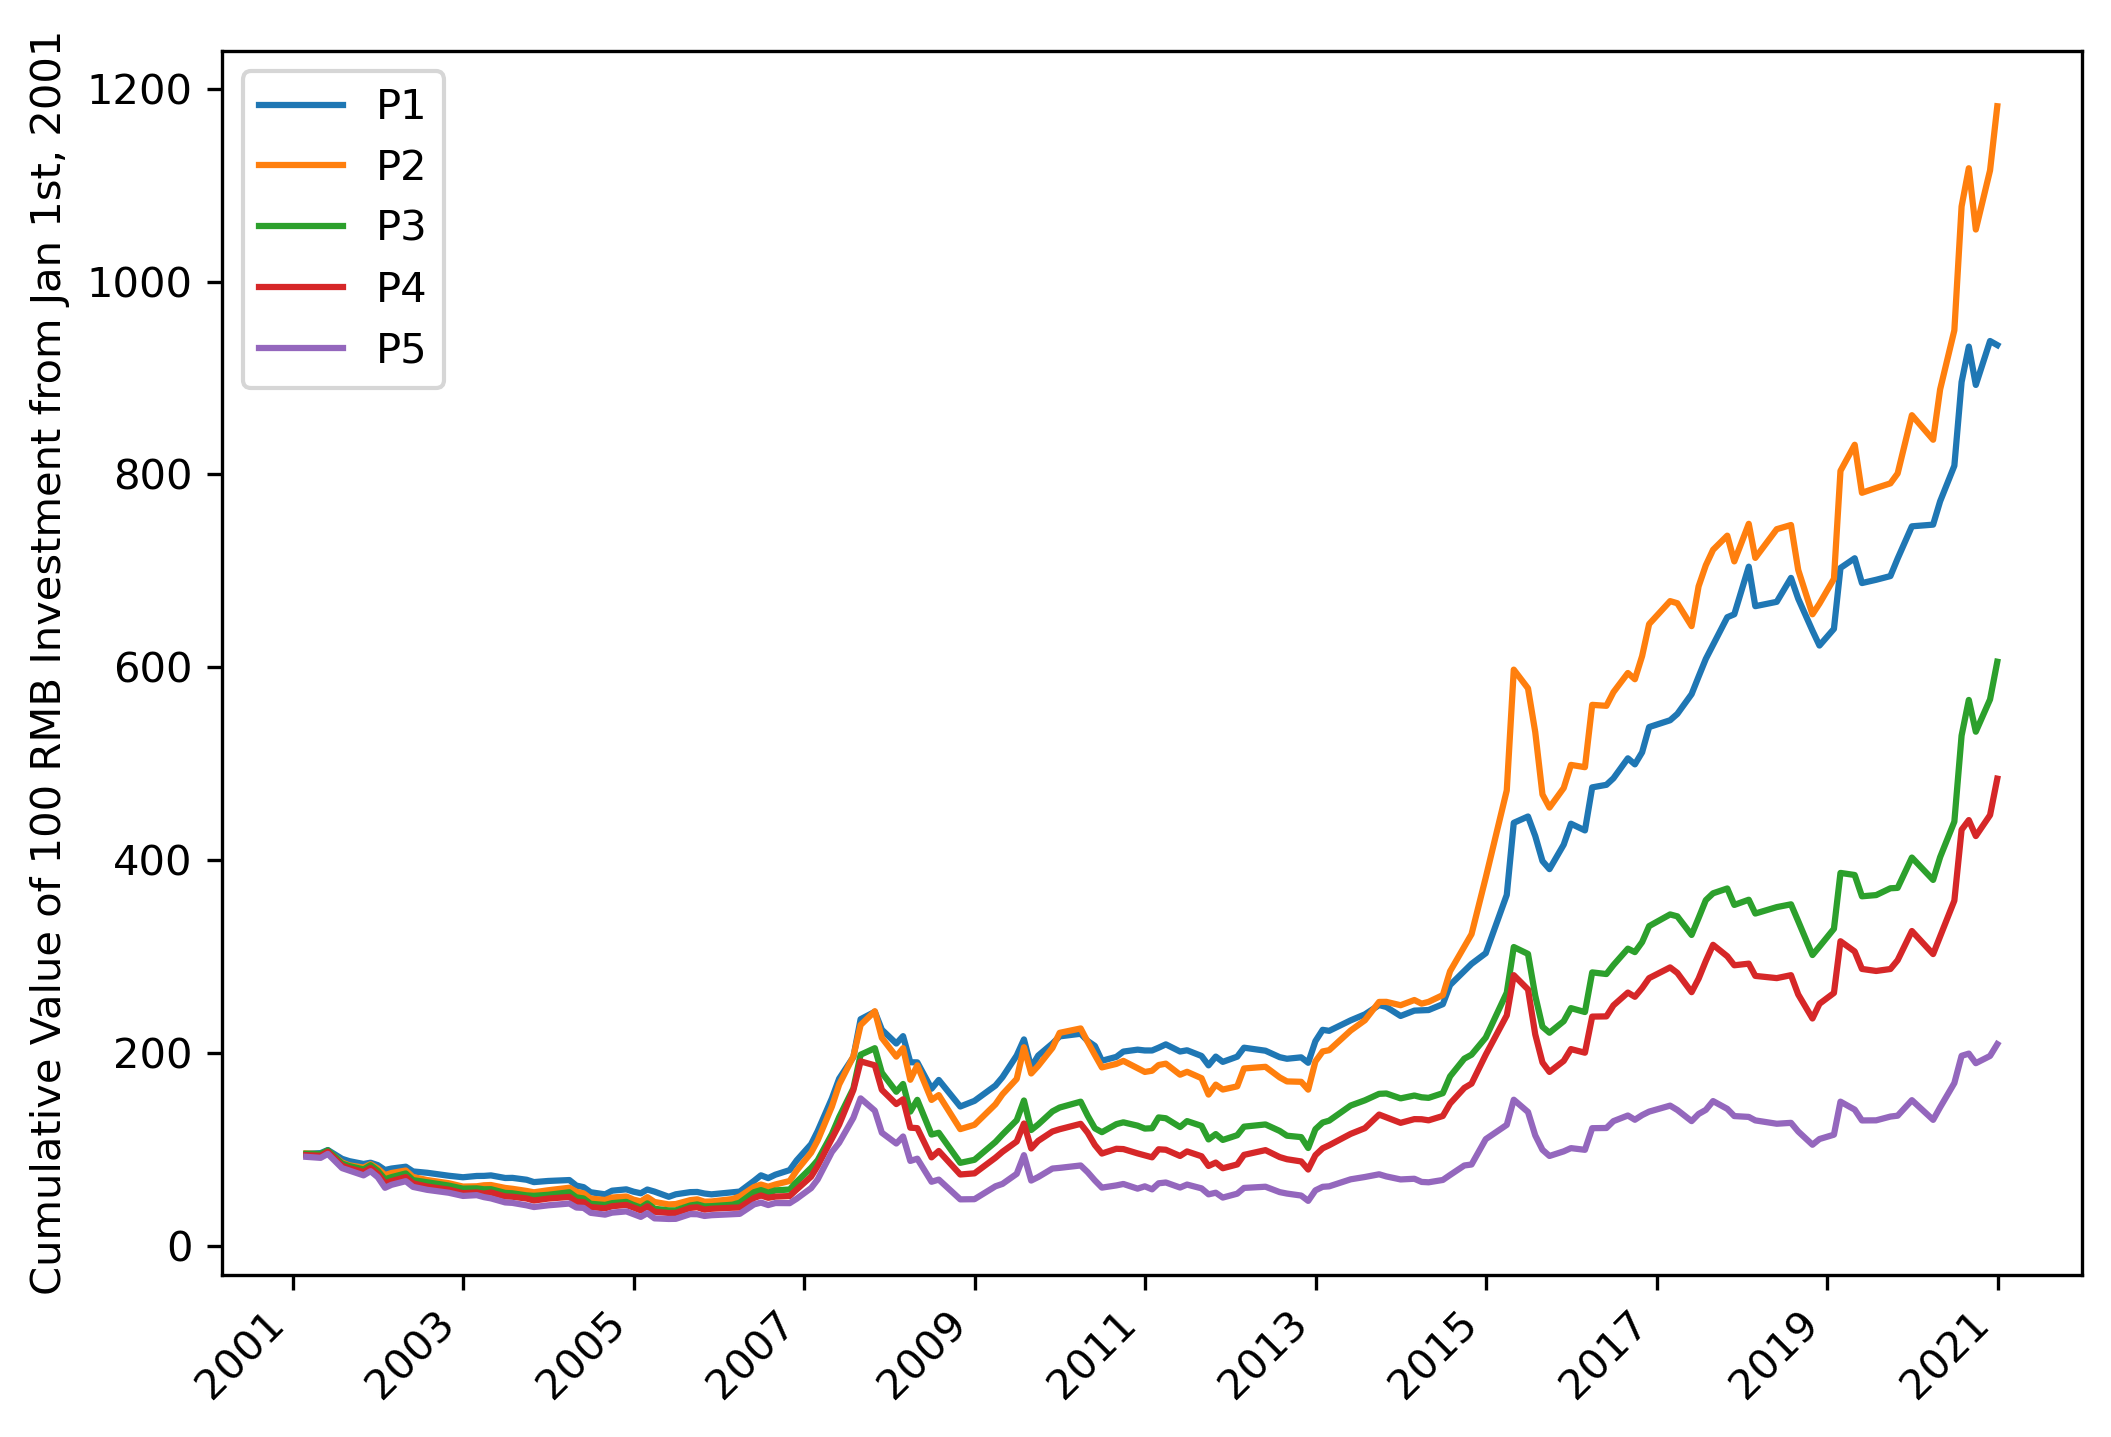

In [19]:
gen_cum_return(df_port_CVW).plot(figsize=(8,6))
tic = ['2001-01-01','2003-01-01', '2005-01-01', '2007-01-01',
'2009-01-01','2011-01-01', '2013-01-01', '2015-01-01',
'2017-01-01','2019-01-01','2021-01-01']
lab = ['2001','2003', '2005', '2007',
'2009','2011', '2013', '2015',
'2017','2019','2021']
plt.xticks(ticks=tic, labels=lab, rotation=45, fontsize=10)
plt.ylabel("Cumulative Value of 100 RMB Investment from Jan 1st, 2001", fontsize=10)
plt.xlabel("", fontsize=10) 
plt.legend(["P1", "P2", "P3", "P4", "P5" ])
plt.savefig('result/figure7.jpg') 

# Benchmark Betting Against Beta

In [20]:
df["date_int"] = (df["date"].apply(lambda x: x.strftime('%Y%m%d'))).astype("int")

In [21]:
def lowHigh_portfolio(subdf):
    """
    Corss-section sort each stock into two portfolios:
    Low Beta Portfolio with index 0;
    high Beta Portfolio with index 1.

    Also, calculate the weight of stock in two portfolios:
    high_weight	is the weight in the high beta portfolio;
    low_weight is the weight in the low beta portfolio.
    """
    subdf["lowHigh"] = pd.qcut(subdf["beta"], 2, labels=["Low", "High"])
    subdf["rank"] = subdf["beta"].rank()
    subdf["avgRank"] = subdf["rank"].mean()
    subdf["Weight_BS"] = subdf["rank"] - subdf["avgRank"]
    subdf["high_weight_BS"] = subdf["Weight_BS"].apply(lambda x: np.max([x, 0]))
    subdf["low_weight_BS"] = subdf["Weight_BS"].apply(lambda x: np.max([-x, 0]))
    subdf["high_weight"] = subdf["high_weight_BS"] /(subdf["high_weight_BS"].sum())
    subdf["low_weight"] =  subdf["low_weight_BS"] /(subdf["low_weight_BS"].sum())
    
    subdf["weight"] = subdf["high_weight"] + subdf["low_weight"]
    
    return subdf.drop(["rank","avgRank",
                       "Weight_BS",
                       "high_weight_BS",
                       "low_weight_BS", 
                       "high_weight", 
                       "low_weight"], axis=1)

df_lowHigh = (df_month.groupby('date').apply(lowHigh_portfolio)
             .rename({"excess_return_original": "excess_return"}, axis=1))

In [22]:
def lowHigh_portfolio_return(subdf):
    """
    Use the two portfolios to construct a betting-against-beta factor portfolio 
    """
    avgBeta = (subdf["beta"]*subdf["weight"]).sum()
    ret = ((subdf["excess_return"]*subdf["weight"]).sum()) / avgBeta
    return ret

df_lowHigh_return = (df_lowHigh
                     .groupby(["date", "lowHigh"])
                     .apply(lowHigh_portfolio_return)
                     .reset_index()
                     .rename({0: "portRet"}, axis=1)
                     .pivot(index="date", columns="lowHigh", values="portRet")
                    )


In [23]:
df_BAB = (pd.DataFrame(df_lowHigh_return.Low-df_lowHigh_return.High)
          .rename({0:"Ret_Month%"},axis=1)
          )
df_BAB = df_BAB.reset_index().query("date >= '2000-12-31'").set_index('date')
df_BAB["CumRet%"] = (df_BAB["Ret_Month%"]+1).cumprod()-1

<ipython-input-24-81b0c690a870>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure1.show()


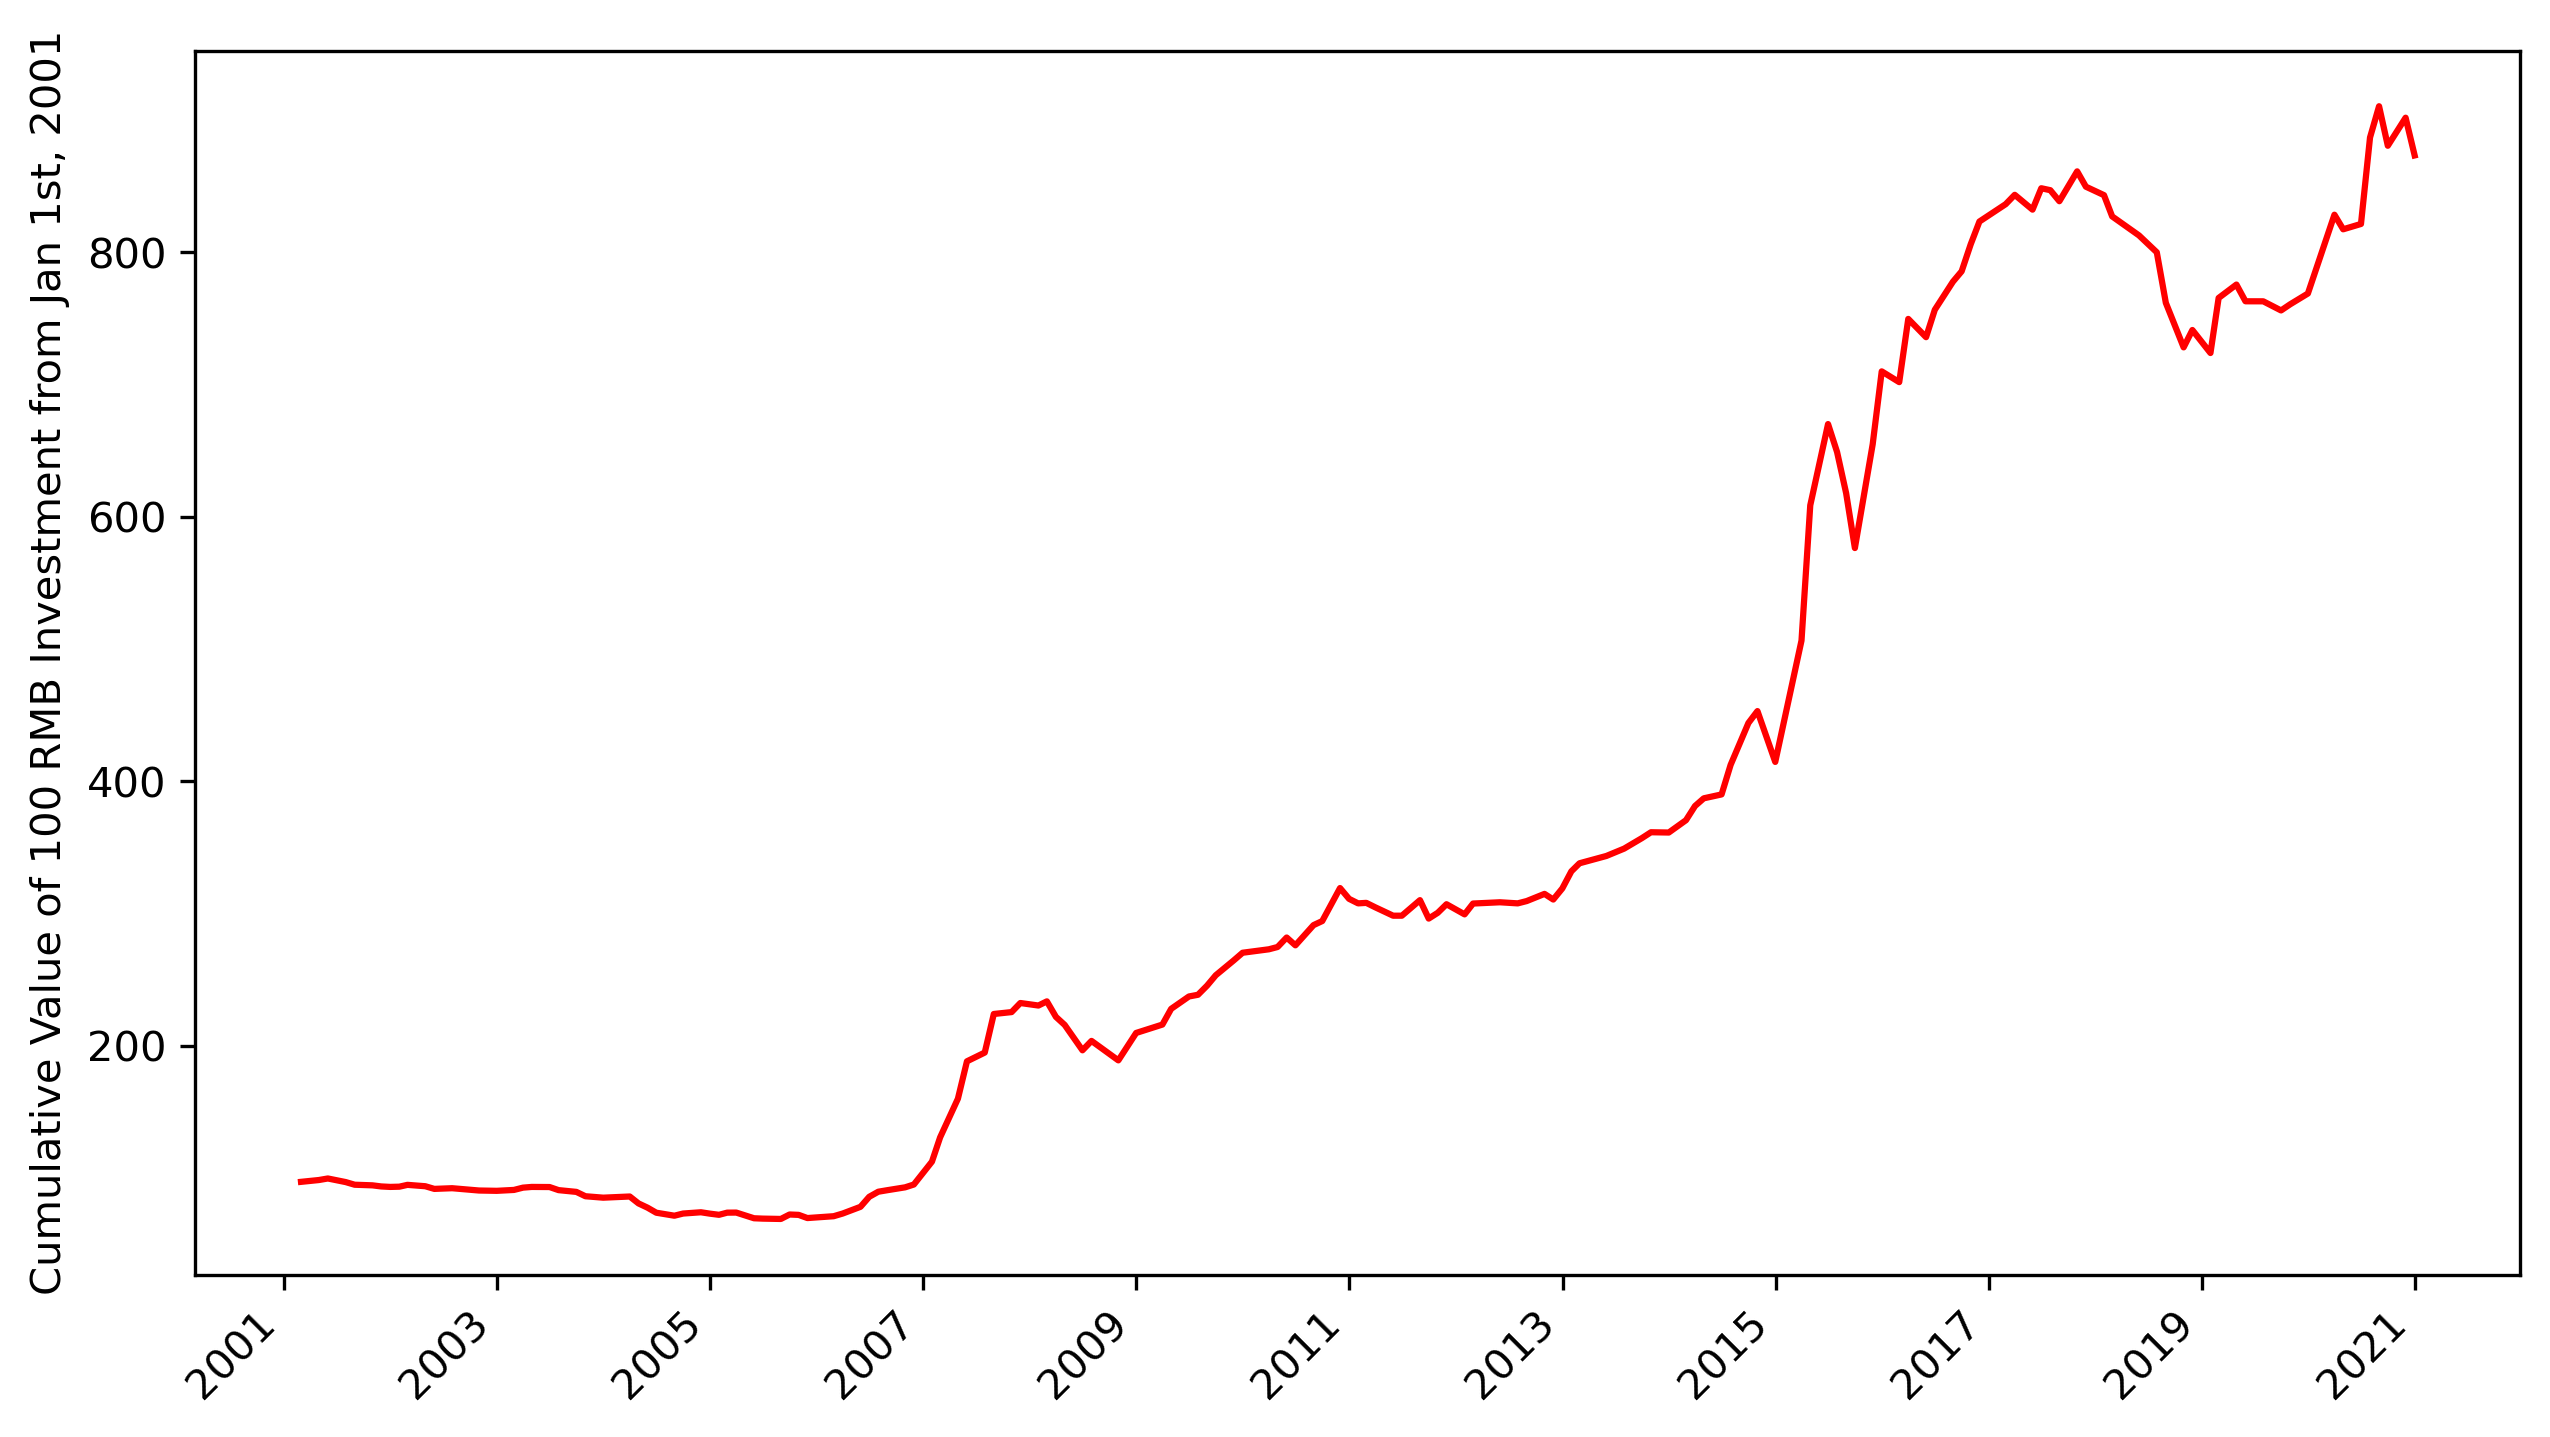

In [24]:
fig = plt.figure(figsize=(10,6))
ax1 = ((df_BAB.loc[:, "CumRet%"]+1)*100).plot(c="r")
figure1 = ax1.figure 
figure1.autofmt_xdate() 
figure1.show()

tic = ['2001-01-01','2003-01-01', '2005-01-01', '2007-01-01',
'2009-01-01','2011-01-01', '2013-01-01', '2015-01-01',
'2017-01-01','2019-01-01','2021-01-01']
lab = ['2001','2003', '2005', '2007',
'2009','2011', '2013', '2015',
'2017','2019','2021']
plt.xticks(ticks=tic, labels=lab, rotation=45, fontsize=10)
plt.ylabel("Cumulative Value of 100 RMB Investment from Jan 1st, 2001", fontsize=10)
plt.xlabel("", fontsize=10) 

plt.savefig('result/figure8.jpg') 

In the code below, we use a trick: In order to reuse the data analysis code we wrote earlier, we can assume that the betting-against-beta portfolio is the portfolio with decile "1".

In [25]:
df_port_BAB = (df_BAB[["Ret_Month%"]]
              .reset_index()
              .rename({"Ret_Month%": "excess_return"}, axis=1)
              )
df_port_BAB["decile"] = 1

In [26]:
# First row Excess Return
def excess_return(df_return):
    """
    Calculate the first row "Excess Return" and their pvalue
    for Portfolio 1, Portfolio 2,..., Portfolio 5
    """
    df = df_return.set_index("date")
    df_result = pd.DataFrame()
    for i in range(1,2):
        df0 = df[df['decile']==i]
        
        y = df0['excess_return']
        x = df0.drop(["decile","excess_return"], axis=1)
        x = sm.add_constant(x)
        results = sm.OLS(y, x).fit(cov_type='HC1')
        
        par0 = pd.Series([results.params[0], results.pvalues[0]])
        par0.name= 'port_{}'.format(i)
        df_result = df_result.append(par0)
        
    df_result.columns = ["Excess_Return%","p-Excess_Return"]
    df_result["Excess_Return%"] = 100 * df_result["Excess_Return%"]
    return df_result.T

# 2nd to 5th row: alpha
def factor_alpha(df_return, df_factor):
    """
    Calculate the 2nd to 5th row "alpha" and their palue
    for Portfolio 1, Portfolio 2,..., Portfolio 5
    """
    df_factor["date"] = pd.to_datetime(df_factor["date"], format="%Y-%m-%d")
    df = pd.merge(df_return, df_factor, on="date", how="left")
    df = df.set_index("date")

    df_result = pd.DataFrame()
    for i in range(1,2):
        df0 = df[df['decile']==i]
        
        y = df0['excess_return']
        x = df0.drop(["decile","excess_return","RF"], axis=1)
        x = sm.add_constant(x)
        results = sm.OLS(y, x).fit(cov_type='HC1')
        
      
        par0 = pd.Series([results.params[0], results.pvalues[0]])
        par0.name= 'port_{}'.format(i)
        df_result = df_result.append(par0)
        
    df_result.columns = ["alpha%","p-alpha"]
    df_result["alpha%"] = 100 * df_result["alpha%"]
    return df_result.T


# row7: beta (realized) and volatility%
def beta_volatility(df_return, df_factor):
    """
    Calculate the 6th row:  beta (realized)	and
    the 7th row volatility%
    for Portfolio 1, Portfolio 2,..., Portfolio 6
    """
    df_factor["date"] = pd.to_datetime(df_factor["date"], format="%Y-%m-%d")
    df = pd.merge(df_return, df_factor, on="date", how="left")
    df = df.set_index("date")

    df_result = pd.DataFrame()
    for i in range(1,2):
        df0 = df[df['decile']==i]
        
        y = df0['excess_return']
        x = df0['MKT']
        x = sm.add_constant(x)
        results = sm.OLS(y, x).fit(cov_type='HC1')
        
        volatility = y.std()
        par0 = pd.Series([results.params[1], volatility])
        par0.name= 'port_{}'.format(i)
        df_result = df_result.append(par0)
        
    df_result.columns = ["beta (realized)", "volatility%"]
    df_result["volatility%"] = df_result["volatility%"]*100*np.sqrt(12)
    # convert the volatility to percentage annualized
    return df_result.T

def generate_table(df_return):
    """
    Use all the function above to form table
    """
    table3_row1 = excess_return(df_return)
    
    df_capm = pd.read_csv("Data/Factor/ChineseCAPM_Classical_Month.csv")
    table3_row2 = factor_alpha(df_return, df_capm)
    table3_row2.index = ["CAPM_alpha%" , "p-CAPM_alpha"]
    
    df_FF3 = pd.read_csv("Data/Factor/ChineseFF3_Classical_Month.csv")
    table3_row3 = factor_alpha(df_return, df_FF3)
    table3_row3.index = ["FF3_alpha%" , "p-FF3_alpha"]
    
    df_Carhart4 = pd.read_csv("Data/Factor/ChineseCarhart4_Classical_Month.csv")
    table3_row4 = factor_alpha(df_return, df_Carhart4)
    table3_row4.index = ["Carhart4_alpha%" , "p-Carhart4_alpha"]
    
    df_FF5 = pd.read_csv("Data/Factor/ChineseFF5_Classical_Month.csv")
    table3_row5 = factor_alpha(df_return, df_FF5)
    table3_row5.index = ["FF5_alpha%" , "p-FF5_alpha"]
    
    df_LSY3 = (pd.read_csv("Data/Factor/CH_3_update_20201231.csv",header=8)
           .rename({"mnthdt":"date","rf_mon":"RF"}, axis=1))
    df_LSY3["date"] =  pd.to_datetime(df_LSY3["date"], format="%Y%m%d").astype("str")
    df_LSY3[["RF", "mktrf", "SMB", "VMG"]] = df_LSY3[["RF", "mktrf", "SMB", "VMG"]]/100
    table3_row9 = factor_alpha(df_return, df_LSY3)
    table3_row9.index = ["LSY3_alpha%" , "p-LSY3_alpha"]
    
    df_LSY4 = (pd.read_csv("Data/Factor/CH_4_fac_update_20201231.csv",header=9)
               .rename({"mnthdt":"date", "rf_mon":"RF"}, axis=1))
    df_LSY4[["RF","mktrf","VMG","SMB","PMO"]] = df_LSY4[["RF","mktrf","VMG","SMB","PMO"]]/100
    df_LSY4["date"] =  pd.to_datetime(df_LSY4["date"], format="%Y%m%d").astype("str")
    table3_row10 = factor_alpha(df_return, df_LSY4)
    table3_row10.index = ["LSY4_alpha%" , "p-LSY4_alpha"]
    
    
    table3_row7 = beta_volatility(df_return, df_factor=df_capm)
    
    table3_row8 = (pd.DataFrame((table3_row1.T["Excess_Return%"]*12) / (table3_row7.T["volatility%"]))
                   .rename({0:"Sharpe Ratio"}, axis=1)
                   .T)
    
    return pd.concat([table3_row1,
                      table3_row2,
                      table3_row3, 
                      table3_row4,
                      table3_row5,
                      table3_row9,
                      table3_row10,
                      table3_row7,
                      table3_row8])

generate_table(df_port_BAB).to_csv("result/table5_pvalue.csv")
generate_table(df_port_BAB)

,port_1
Excess_Return%,1.496664
p-Excess_Return,0.000262
CAPM_alpha%,1.282182
p-CAPM_alpha,0.000072
FF3_alpha%,1.168437
p-FF3_alpha,0.000043
Carhart4_alpha%,1.109036
p-Carhart4_alpha,0.000172
FF5_alpha%,1.077666
p-FF5_alpha,0.000852


In [27]:
def excess_return(df_return):
    """
    Calculate the first row "Excess Return" and their pvalue
    for Portfolio 1, Portfolio 2,..., Portfolio 5
    """
    df = df_return.set_index("date")
    df_result = pd.DataFrame()
    for i in range(1,2):
        df0 = df[df['decile']==i]
        
        y = df0['excess_return']
        x = df0.drop(["decile","excess_return"], axis=1)
        x = sm.add_constant(x)
        results = sm.OLS(y, x).fit(cov_type='HC1')
        
        par0 = pd.Series([results.params[0], results.tvalues[0]])
        par0.name= 'port_{}'.format(i)
        df_result = df_result.append(par0)
        
    df_result.columns = ["Excess_Return%","t-Excess_Return"]
    df_result["Excess_Return%"] = 100 * df_result["Excess_Return%"]
    return df_result.T

# 2nd to 5th row: alpha
def factor_alpha(df_return, df_factor):
    """
    Calculate the 2nd to 5th row "alpha" and their palue
    for Portfolio 1, Portfolio 2,..., Portfolio 5
    """
    df_factor["date"] = pd.to_datetime(df_factor["date"], format="%Y-%m-%d")
    df = pd.merge(df_return, df_factor, on="date", how="left")
    df = df.set_index("date")

    df_result = pd.DataFrame()
    for i in range(1,2):
        df0 = df[df['decile']==i]
        
        y = df0['excess_return']
        x = df0.drop(["decile","excess_return","RF"], axis=1)
        x = sm.add_constant(x)
        results = sm.OLS(y, x).fit(cov_type='HC1')
        
      
        par0 = pd.Series([results.params[0], results.tvalues[0]])
        par0.name= 'port_{}'.format(i)
        df_result = df_result.append(par0)
        
    df_result.columns = ["alpha%","t-alpha"]
    df_result["alpha%"] = 100 * df_result["alpha%"]
    return df_result.T


# row7: beta (realized) and volatility%
def beta_volatility(df_return, df_factor):
    """
    Calculate the 6th row:  beta (realized)	and
    the 7th row volatility%
    for Portfolio 1, Portfolio 2,..., Portfolio 6
    """
    df_factor["date"] = pd.to_datetime(df_factor["date"], format="%Y-%m-%d")
    df = pd.merge(df_return, df_factor, on="date", how="left")
    df = df.set_index("date")

    df_result = pd.DataFrame()
    for i in range(1,2):
        df0 = df[df['decile']==i]
        
        y = df0['excess_return']
        x = df0['MKT']
        x = sm.add_constant(x)
        results = sm.OLS(y, x).fit(cov_type='HC1')
        
        volatility = y.std()
        par0 = pd.Series([results.params[1], volatility])
        par0.name= 'port_{}'.format(i)
        df_result = df_result.append(par0)
        
    df_result.columns = ["beta (realized)", "volatility%"]
    df_result["volatility%"] = df_result["volatility%"]*100*np.sqrt(12)
    # convert the volatility to percentage annualized
    return df_result.T

def generate_table(df_return):
    """
    Use all the function above to form table
    """
    table3_row1 = excess_return(df_return)
    
    df_capm = pd.read_csv("Data/Factor/ChineseCAPM_Classical_Month.csv")
    table3_row2 = factor_alpha(df_return, df_capm)
    table3_row2.index = ["CAPM_alpha%" , "t-CAPM_alpha"]
    
    df_FF3 = pd.read_csv("Data/Factor/ChineseFF3_Classical_Month.csv")
    table3_row3 = factor_alpha(df_return, df_FF3)
    table3_row3.index = ["FF3_alpha%" , "t-FF3_alpha"]
    
    df_Carhart4 = pd.read_csv("Data/Factor/ChineseCarhart4_Classical_Month.csv")
    table3_row4 = factor_alpha(df_return, df_Carhart4)
    table3_row4.index = ["Carhart4_alpha%" , "t-Carhart4_alpha"]
    
    df_FF5 = pd.read_csv("Data/Factor/ChineseFF5_Classical_Month.csv")
    table3_row5 = factor_alpha(df_return, df_FF5)
    table3_row5.index = ["FF5_alpha%" , "t-FF5_alpha"]
    
    df_LSY3 = (pd.read_csv("Data/Factor/CH_3_update_20201231.csv",header=8)
           .rename({"mnthdt":"date","rf_mon":"RF"}, axis=1))
    df_LSY3["date"] =  pd.to_datetime(df_LSY3["date"], format="%Y%m%d").astype("str")
    df_LSY3[["RF", "mktrf", "SMB", "VMG"]] = df_LSY3[["RF", "mktrf", "SMB", "VMG"]]/100
    table3_row9 = factor_alpha(df_return, df_LSY3)
    table3_row9.index = ["LSY3_alpha%" , "p-LSY3_alpha"]
    
    df_LSY4 = (pd.read_csv("Data/Factor/CH_4_fac_update_20201231.csv",header=9)
               .rename({"mnthdt":"date", "rf_mon":"RF"}, axis=1))
    df_LSY4[["RF","mktrf","VMG","SMB","PMO"]] = df_LSY4[["RF","mktrf","VMG","SMB","PMO"]]/100
    df_LSY4["date"] =  pd.to_datetime(df_LSY4["date"], format="%Y%m%d").astype("str")
    table3_row10 = factor_alpha(df_return, df_LSY4)
    table3_row10.index = ["LSY4_alpha%" , "p-LSY4_alpha"]
    
    
    table3_row7 = beta_volatility(df_return, df_factor=df_capm)
    
    table3_row8 = (pd.DataFrame((table3_row1.T["Excess_Return%"]*12) / (table3_row7.T["volatility%"]))
                   .rename({0:"Sharpe Ratio"}, axis=1)
                   .T)
    
    return pd.concat([table3_row1,
                      table3_row2,
                      table3_row3, 
                      table3_row4,
                      table3_row5,
                      table3_row9,
                      table3_row10,
                      table3_row7,
                      table3_row8])

generate_table(df_port_BAB).to_csv("result/table5.csv")
generate_table(df_port_BAB)

,port_1
Excess_Return%,1.496664
t-Excess_Return,3.650138
CAPM_alpha%,1.282182
t-CAPM_alpha,3.970998
FF3_alpha%,1.168437
t-FF3_alpha,4.090445
Carhart4_alpha%,1.109036
t-Carhart4_alpha,3.756575
FF5_alpha%,1.077666
t-FF5_alpha,3.335425


# Feasible BAB

In [28]:
future = pd.read_parquet("Data/Original/future.parquet")

In [29]:
def drop_small_stocks(subdf):
    thre = subdf["s_val_mv"].quantile(0.30)
    subdf = subdf[subdf["s_val_mv"]>thre] 
    return subdf

In [30]:
df_month_large = (df_month.groupby("date")
                  .apply(drop_small_stocks)
                  .drop("date", axis=1)
                  .reset_index()
                  .drop("level_1", axis=1))

In [31]:
def low_high(subdf):    
    subdf["lowHigh"] = pd.qcut(subdf["beta"], 2, labels=["Low", "High"])
    return subdf
df_month_lowHigh = df_month_large.groupby("date").apply(low_high)

In [32]:
df_month_low = df_month_lowHigh.query("lowHigh == 'Low'")

In [33]:
def low_portfolio_return(subdf):
    return_EW = subdf["excess_return_original"].mean()
    beta_EW = subdf["beta"].mean()
    return_TVW = ((subdf["excess_return_original"]*subdf["s_val_mv"]).sum()) / (subdf["s_val_mv"].sum())
    beta_TVW = ((subdf["beta"]*subdf["s_val_mv"]).sum()) / (subdf["s_val_mv"].sum())
    return_CVW = ((subdf["excess_return_original"]*subdf["s_dq_mv"]).sum()) / (subdf["s_dq_mv"].sum())
    beta_CVW = ((subdf["beta"]*subdf["s_dq_mv"]).sum()) / (subdf["s_dq_mv"].sum())
    return pd.DataFrame((return_EW,  beta_EW, 
                         return_TVW, beta_TVW,
                         return_CVW, beta_CVW))

df_port_low=(df_month_low
                     .groupby("date")
                     .apply(low_portfolio_return)
                     .reset_index()
                     .rename({0:"value"}, axis=1)
                     .pivot(index="date", columns="level_1", values="value")
                     .rename({0: "return_EW",
                              1: "beta_EW",
                              2: "return_TVW",
                              3: "beta_TVW",
                              4: "return_CVW",
                              5: "beta_CVW"}, axis=1)
                    )

In [34]:
df_port_low

level_1,return_EW,beta_EW,return_TVW,beta_TVW,return_CVW,beta_CVW
date,,,,,,
2000-07-31,0.057363,0.768675,0.064405,0.749088,0.053047,0.758158
2000-08-31,0.007350,0.772762,-0.001890,0.751325,0.002538,0.758697
2000-10-31,0.025733,0.775259,0.017907,0.759338,0.018294,0.767485
2000-11-30,0.063671,0.752223,0.061305,0.744829,0.057660,0.750219
2001-02-28,-0.049892,0.757494,-0.045268,0.752936,-0.043305,0.753066
...,...,...,...,...,...,...
2020-07-31,0.152904,0.843229,0.124160,0.773248,0.128757,0.780774
2020-08-31,0.039623,0.844163,0.037122,0.767345,0.041936,0.774864
2020-09-30,-0.062474,0.840567,-0.047284,0.766932,-0.048947,0.775474


In [35]:
IF = future.query("s_info_windcode == 'IF.CFE'")
IF["IF_return"] =  (IF["s_dq_settle"]-IF["s_dq_presettle"])/IF["s_dq_presettle"]
IF["date"] = pd.to_datetime(IF["trade_dt"], format="%Y%m%d")
IF = IF[["date","IF_return"]]

<ipython-input-35-bfc89e418a5f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IF["IF_return"] =  (IF["s_dq_settle"]-IF["s_dq_presettle"])/IF["s_dq_presettle"]
<ipython-input-35-bfc89e418a5f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IF["date"] = pd.to_datetime(IF["trade_dt"], format="%Y%m%d")


In [36]:
def month_return(subdf):
    '''
    Convert the daily original return to monthly return
    '''
    subdf_month = (subdf[["date","IF_return"]]
                   .set_index("date")
                   .resample("M")
                   .apply(lambda df: (1+df).prod() - 1)
                  )
    return subdf_month

IF = IF.set_index("date").resample("M").apply(lambda df: (1+df).prod() - 1)

In [37]:
df_port_FBAB = pd.merge(df_port_low, IF, how='inner', left_index=True, right_index=True)

In [38]:
df_port_FBAB["EW"] = df_port_FBAB["return_EW"] - df_port_FBAB["beta_EW"]*df_port_FBAB["IF_return"]
df_port_FBAB["TVW"] = df_port_FBAB["return_TVW"] - df_port_FBAB["beta_TVW"]*df_port_FBAB["IF_return"]
df_port_FBAB["CVW"] = df_port_FBAB["return_CVW"] - df_port_FBAB["beta_CVW"]*df_port_FBAB["IF_return"]

In [39]:
df_port_FBABTVW  = df_port_FBAB[["TVW"]].reset_index().rename({"TVW":"excess_return"}, axis=1)
df_port_FBABTVW["decile"]=1

df_port_FBABCVW  = df_port_FBAB[["CVW"]].reset_index().rename({"CVW":"excess_return"}, axis=1)
df_port_FBABCVW["decile"]=1

In [40]:
# First row Excess Return
def excess_return(df_return):
    """
    Calculate the first row "Excess Return" and their pvalue
    for Portfolio 1, Portfolio 2,..., Portfolio 5
    """
    df = df_return.set_index("date")
    df_result = pd.DataFrame()
    for i in range(1,2):
        df0 = df[df['decile']==i]
        
        y = df0['excess_return']
        x = df0.drop(["decile","excess_return"], axis=1)
        x = sm.add_constant(x)
        results = sm.OLS(y, x).fit(cov_type='HC1')
        
        par0 = pd.Series([results.params[0], results.pvalues[0]])
        par0.name= 'port_{}'.format(i)
        df_result = df_result.append(par0)
        
    df_result.columns = ["Excess_Return%","p-Excess_Return"]
    df_result["Excess_Return%"] = 100 * df_result["Excess_Return%"]
    return df_result.T

# 2nd to 5th row: alpha
def factor_alpha(df_return, df_factor):
    """
    Calculate the 2nd to 5th row "alpha" and their palue
    for Portfolio 1, Portfolio 2,..., Portfolio 5
    """
    df_factor["date"] = pd.to_datetime(df_factor["date"], format="%Y-%m-%d")
    df = pd.merge(df_return, df_factor, on="date", how="left")
    df = df.set_index("date")

    df_result = pd.DataFrame()
    for i in range(1,2):
        df0 = df[df['decile']==i]
        
        y = df0['excess_return']
        x = df0.drop(["decile","excess_return","RF"], axis=1)
        x = sm.add_constant(x)
        results = sm.OLS(y, x).fit(cov_type='HC1')
        
      
        par0 = pd.Series([results.params[0], results.pvalues[0]])
        par0.name= 'port_{}'.format(i)
        df_result = df_result.append(par0)
        
    df_result.columns = ["alpha%","p-alpha"]
    df_result["alpha%"] = 100 * df_result["alpha%"]
    return df_result.T


# row7: beta (realized) and volatility%
def beta_volatility(df_return, df_factor):
    """
    Calculate the 6th row:  beta (realized)	and
    the 7th row volatility%
    for Portfolio 1, Portfolio 2,..., Portfolio 6
    """
    df_factor["date"] = pd.to_datetime(df_factor["date"], format="%Y-%m-%d")
    df = pd.merge(df_return, df_factor, on="date", how="left")
    df = df.set_index("date")

    df_result = pd.DataFrame()
    for i in range(1,2):
        df0 = df[df['decile']==i]
        
        y = df0['excess_return']
        x = df0['MKT']
        x = sm.add_constant(x)
        results = sm.OLS(y, x).fit(cov_type='HC1')
        
        volatility = y.std()
        par0 = pd.Series([results.params[1], volatility])
        par0.name= 'port_{}'.format(i)
        df_result = df_result.append(par0)
        
    df_result.columns = ["beta (realized)", "volatility%"]
    df_result["volatility%"] = df_result["volatility%"]*100*np.sqrt(12)
    # convert the volatility to percentage annualized
    return df_result.T

def generate_table(df_return):
    """
    Use all the function above to form table
    """
    table3_row1 = excess_return(df_return)
    
    df_capm = pd.read_csv("Data/Factor/ChineseCAPM_Classical_Month.csv")
    table3_row2 = factor_alpha(df_return, df_capm)
    table3_row2.index = ["CAPM_alpha%" , "p-CAPM_alpha"]
    
    df_FF3 = pd.read_csv("Data/Factor/ChineseFF3_Classical_Month.csv")
    table3_row3 = factor_alpha(df_return, df_FF3)
    table3_row3.index = ["FF3_alpha%" , "p-FF3_alpha"]
    
    df_Carhart4 = pd.read_csv("Data/Factor/ChineseCarhart4_Classical_Month.csv")
    table3_row4 = factor_alpha(df_return, df_Carhart4)
    table3_row4.index = ["Carhart4_alpha%" , "p-Carhart4_alpha"]
    
    df_FF5 = pd.read_csv("Data/Factor/ChineseFF5_Classical_Month.csv")
    table3_row5 = factor_alpha(df_return, df_FF5)
    table3_row5.index = ["FF5_alpha%" , "p-FF5_alpha"]
    
    df_LSY3 = (pd.read_csv("Data/Factor/CH_3_update_20201231.csv",header=8)
           .rename({"mnthdt":"date","rf_mon":"RF"}, axis=1))
    df_LSY3["date"] =  pd.to_datetime(df_LSY3["date"], format="%Y%m%d").astype("str")
    df_LSY3[["RF", "mktrf", "SMB", "VMG"]] = df_LSY3[["RF", "mktrf", "SMB", "VMG"]]/100
    table3_row9 = factor_alpha(df_return, df_LSY3)
    table3_row9.index = ["LSY3_alpha%" , "p-LSY3_alpha"]
    
    df_LSY4 = (pd.read_csv("Data/Factor/CH_4_fac_update_20201231.csv",header=9)
               .rename({"mnthdt":"date", "rf_mon":"RF"}, axis=1))
    df_LSY4[["RF","mktrf","VMG","SMB","PMO"]] = df_LSY4[["RF","mktrf","VMG","SMB","PMO"]]/100
    df_LSY4["date"] =  pd.to_datetime(df_LSY4["date"], format="%Y%m%d").astype("str")
    table3_row10 = factor_alpha(df_return, df_LSY4)
    table3_row10.index = ["LSY4_alpha%" , "p-LSY4_alpha"]
    
    
    table3_row7 = beta_volatility(df_return, df_factor=df_capm)
    
    table3_row8 = (pd.DataFrame((table3_row1.T["Excess_Return%"]*12) / (table3_row7.T["volatility%"]))
                   .rename({0:"Sharpe Ratio"}, axis=1)
                   .T)
    
    return pd.concat([table3_row1,
                      table3_row2,
                      table3_row3, 
                      table3_row4,
                      table3_row5,
                      table3_row9,
                      table3_row10,
                      table3_row7,
                      table3_row8])


In [41]:
generate_table(df_port_FBABTVW).to_csv("result/table6_pvalue.csv")
generate_table(df_port_FBABTVW)

,port_1
Excess_Return%,0.864693
p-Excess_Return,0.002675
CAPM_alpha%,0.769583
p-CAPM_alpha,0.001325
FF3_alpha%,0.650638
p-FF3_alpha,0.002904
Carhart4_alpha%,0.604742
p-Carhart4_alpha,0.004391
FF5_alpha%,0.836425
p-FF5_alpha,0.001345


In [42]:
generate_table(df_port_FBABCVW).to_csv("result/table7_pvalue.csv")
generate_table(df_port_FBABCVW)

,port_1
Excess_Return%,0.890748
p-Excess_Return,0.001964
CAPM_alpha%,0.813771
p-CAPM_alpha,0.000770
FF3_alpha%,0.711237
p-FF3_alpha,0.001640
Carhart4_alpha%,0.663764
p-Carhart4_alpha,0.002545
FF5_alpha%,0.932371
p-FF5_alpha,0.000515


In [43]:
def excess_return(df_return):
    """
    Calculate the first row "Excess Return" and their pvalue
    for Portfolio 1, Portfolio 2,..., Portfolio 5
    """
    df = df_return.set_index("date")
    df_result = pd.DataFrame()
    for i in range(1,2):
        df0 = df[df['decile']==i]
        
        y = df0['excess_return']
        x = df0.drop(["decile","excess_return"], axis=1)
        x = sm.add_constant(x)
        results = sm.OLS(y, x).fit(cov_type='HC1')
        
        par0 = pd.Series([results.params[0], results.tvalues[0]])
        par0.name= 'port_{}'.format(i)
        df_result = df_result.append(par0)
        
    df_result.columns = ["Excess_Return%","t-Excess_Return"]
    df_result["Excess_Return%"] = 100 * df_result["Excess_Return%"]
    return df_result.T

# 2nd to 5th row: alpha
def factor_alpha(df_return, df_factor):
    """
    Calculate the 2nd to 5th row "alpha" and their palue
    for Portfolio 1, Portfolio 2,..., Portfolio 5
    """
    df_factor["date"] = pd.to_datetime(df_factor["date"], format="%Y-%m-%d")
    df = pd.merge(df_return, df_factor, on="date", how="left")
    df = df.set_index("date")

    df_result = pd.DataFrame()
    for i in range(1,2):
        df0 = df[df['decile']==i]
        
        y = df0['excess_return']
        x = df0.drop(["decile","excess_return","RF"], axis=1)
        x = sm.add_constant(x)
        results = sm.OLS(y, x).fit(cov_type='HC1')
        
      
        par0 = pd.Series([results.params[0], results.tvalues[0]])
        par0.name= 'port_{}'.format(i)
        df_result = df_result.append(par0)
        
    df_result.columns = ["alpha%","t-alpha"]
    df_result["alpha%"] = 100 * df_result["alpha%"]
    return df_result.T


# row7: beta (realized) and volatility%
def beta_volatility(df_return, df_factor):
    """
    Calculate the 6th row:  beta (realized)	and
    the 7th row volatility%
    for Portfolio 1, Portfolio 2,..., Portfolio 6
    """
    df_factor["date"] = pd.to_datetime(df_factor["date"], format="%Y-%m-%d")
    df = pd.merge(df_return, df_factor, on="date", how="left")
    df = df.set_index("date")

    df_result = pd.DataFrame()
    for i in range(1,2):
        df0 = df[df['decile']==i]
        
        y = df0['excess_return']
        x = df0['MKT']
        x = sm.add_constant(x)
        results = sm.OLS(y, x).fit(cov_type='HC1')
        
        volatility = y.std()
        par0 = pd.Series([results.params[1], volatility])
        par0.name= 'port_{}'.format(i)
        df_result = df_result.append(par0)
        
    df_result.columns = ["beta (realized)", "volatility%"]
    df_result["volatility%"] = df_result["volatility%"]*100*np.sqrt(12)
    # convert the volatility to percentage annualized
    return df_result.T

def generate_table(df_return):
    """
    Use all the function above to form table
    """
    table3_row1 = excess_return(df_return)
    
    df_capm = pd.read_csv("Data/Factor/ChineseCAPM_Classical_Month.csv")
    table3_row2 = factor_alpha(df_return, df_capm)
    table3_row2.index = ["CAPM_alpha%" , "t-CAPM_alpha"]
    
    df_FF3 = pd.read_csv("Data/Factor/ChineseFF3_Classical_Month.csv")
    table3_row3 = factor_alpha(df_return, df_FF3)
    table3_row3.index = ["FF3_alpha%" , "t-FF3_alpha"]
    
    df_Carhart4 = pd.read_csv("Data/Factor/ChineseCarhart4_Classical_Month.csv")
    table3_row4 = factor_alpha(df_return, df_Carhart4)
    table3_row4.index = ["Carhart4_alpha%" , "t-Carhart4_alpha"]
    
    df_FF5 = pd.read_csv("Data/Factor/ChineseFF5_Classical_Month.csv")
    table3_row5 = factor_alpha(df_return, df_FF5)
    table3_row5.index = ["FF5_alpha%" , "t-FF5_alpha"]
    
    df_LSY3 = (pd.read_csv("Data/Factor/CH_3_update_20201231.csv",header=8)
           .rename({"mnthdt":"date","rf_mon":"RF"}, axis=1))
    df_LSY3["date"] =  pd.to_datetime(df_LSY3["date"], format="%Y%m%d").astype("str")
    df_LSY3[["RF", "mktrf", "SMB", "VMG"]] = df_LSY3[["RF", "mktrf", "SMB", "VMG"]]/100
    table3_row9 = factor_alpha(df_return, df_LSY3)
    table3_row9.index = ["LSY3_alpha%" , "p-LSY3_alpha"]
    
    df_LSY4 = (pd.read_csv("Data/Factor/CH_4_fac_update_20201231.csv",header=9)
               .rename({"mnthdt":"date", "rf_mon":"RF"}, axis=1))
    df_LSY4[["RF","mktrf","VMG","SMB","PMO"]] = df_LSY4[["RF","mktrf","VMG","SMB","PMO"]]/100
    df_LSY4["date"] =  pd.to_datetime(df_LSY4["date"], format="%Y%m%d").astype("str")
    table3_row10 = factor_alpha(df_return, df_LSY4)
    table3_row10.index = ["LSY4_alpha%" , "p-LSY4_alpha"]
    
    
    table3_row7 = beta_volatility(df_return, df_factor=df_capm)
    
    table3_row8 = (pd.DataFrame((table3_row1.T["Excess_Return%"]*12) / (table3_row7.T["volatility%"]))
                   .rename({0:"Sharpe Ratio"}, axis=1)
                   .T)
    
    return pd.concat([table3_row1,
                      table3_row2,
                      table3_row3, 
                      table3_row4,
                      table3_row5,
                      table3_row9,
                      table3_row10,
                      table3_row7,
                      table3_row8])


In [44]:
generate_table(df_port_FBABTVW).to_csv("result/table6.csv")
generate_table(df_port_FBABTVW)

,port_1
Excess_Return%,0.864693
t-Excess_Return,3.002833
CAPM_alpha%,0.769583
t-CAPM_alpha,3.210440
FF3_alpha%,0.650638
t-FF3_alpha,2.977684
Carhart4_alpha%,0.604742
t-Carhart4_alpha,2.848586
FF5_alpha%,0.836425
t-FF5_alpha,3.206234


In [45]:
generate_table(df_port_FBABCVW).to_csv("result/table7.csv")
generate_table(df_port_FBABCVW)

,port_1
Excess_Return%,0.890748
t-Excess_Return,3.095663
CAPM_alpha%,0.813771
t-CAPM_alpha,3.363229
FF3_alpha%,0.711237
t-FF3_alpha,3.148762
Carhart4_alpha%,0.663764
t-Carhart4_alpha,3.017950
FF5_alpha%,0.932371
t-FF5_alpha,3.472684


In [46]:
df_port_FBABTVW = df_port_FBABTVW[["date","excess_return"]].set_index("date")
df_port_FBABTVW["CumRet%"] = (df_port_FBABTVW["excess_return"]+1).cumprod()-1


In [47]:

df_port_FBABCVW = df_port_FBABCVW[["date","excess_return"]].set_index("date")
df_port_FBABCVW["CumRet%"] = (df_port_FBABCVW["excess_return"]+1).cumprod()-1

<ipython-input-48-15f915ac0556>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure1.show()


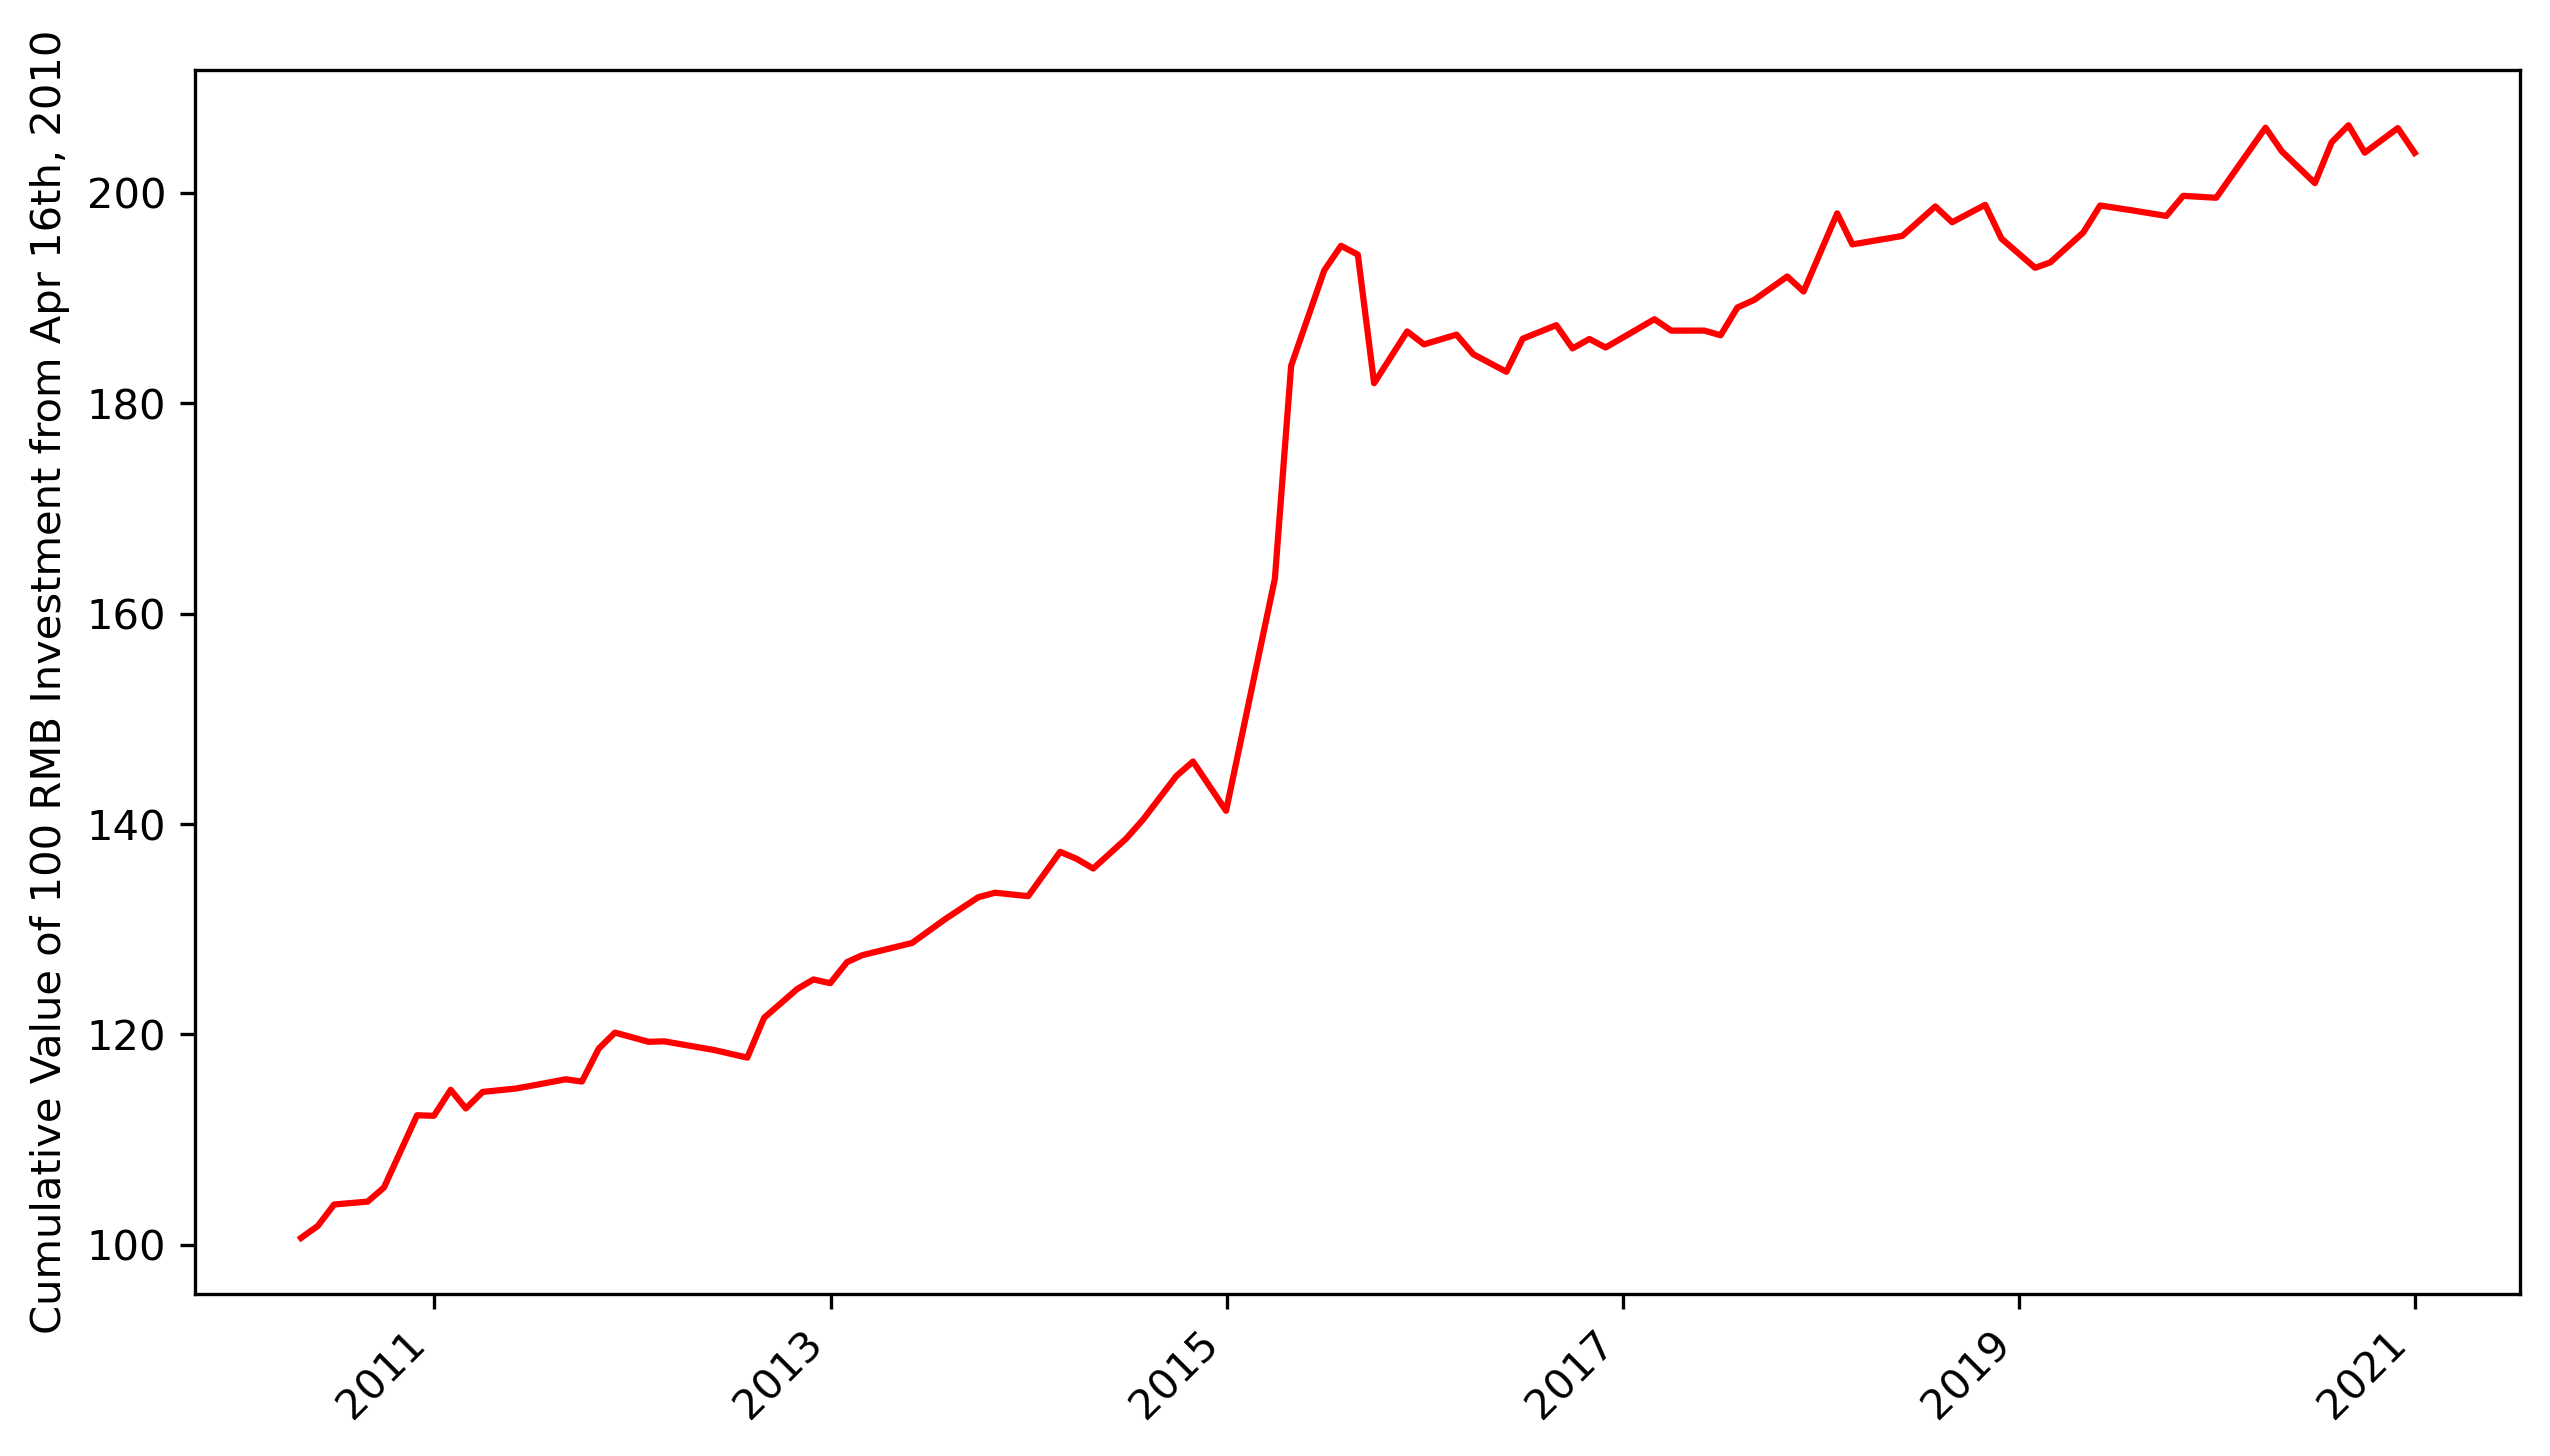

In [48]:
fig = plt.figure(figsize=(10,6))
ax1 = ((df_port_FBABTVW.loc[:, "CumRet%"]+1)*100).plot(c="r")
figure1 = ax1.figure 
figure1.autofmt_xdate() 
figure1.show()

tic = ['2011-01-01', '2013-01-01', '2015-01-01',
'2017-01-01','2019-01-01','2021-01-01']
lab = ['2011', '2013', '2015',
'2017','2019','2021']
plt.xticks(ticks=tic, labels=lab, rotation=45, fontsize=10)
plt.ylabel("Cumulative Value of 100 RMB Investment from Apr 16th, 2010", fontsize=10)
plt.xlabel("", fontsize=10) 

plt.savefig('result/figure9.jpg') 

<ipython-input-49-f164b24ae7f2>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure1.show()


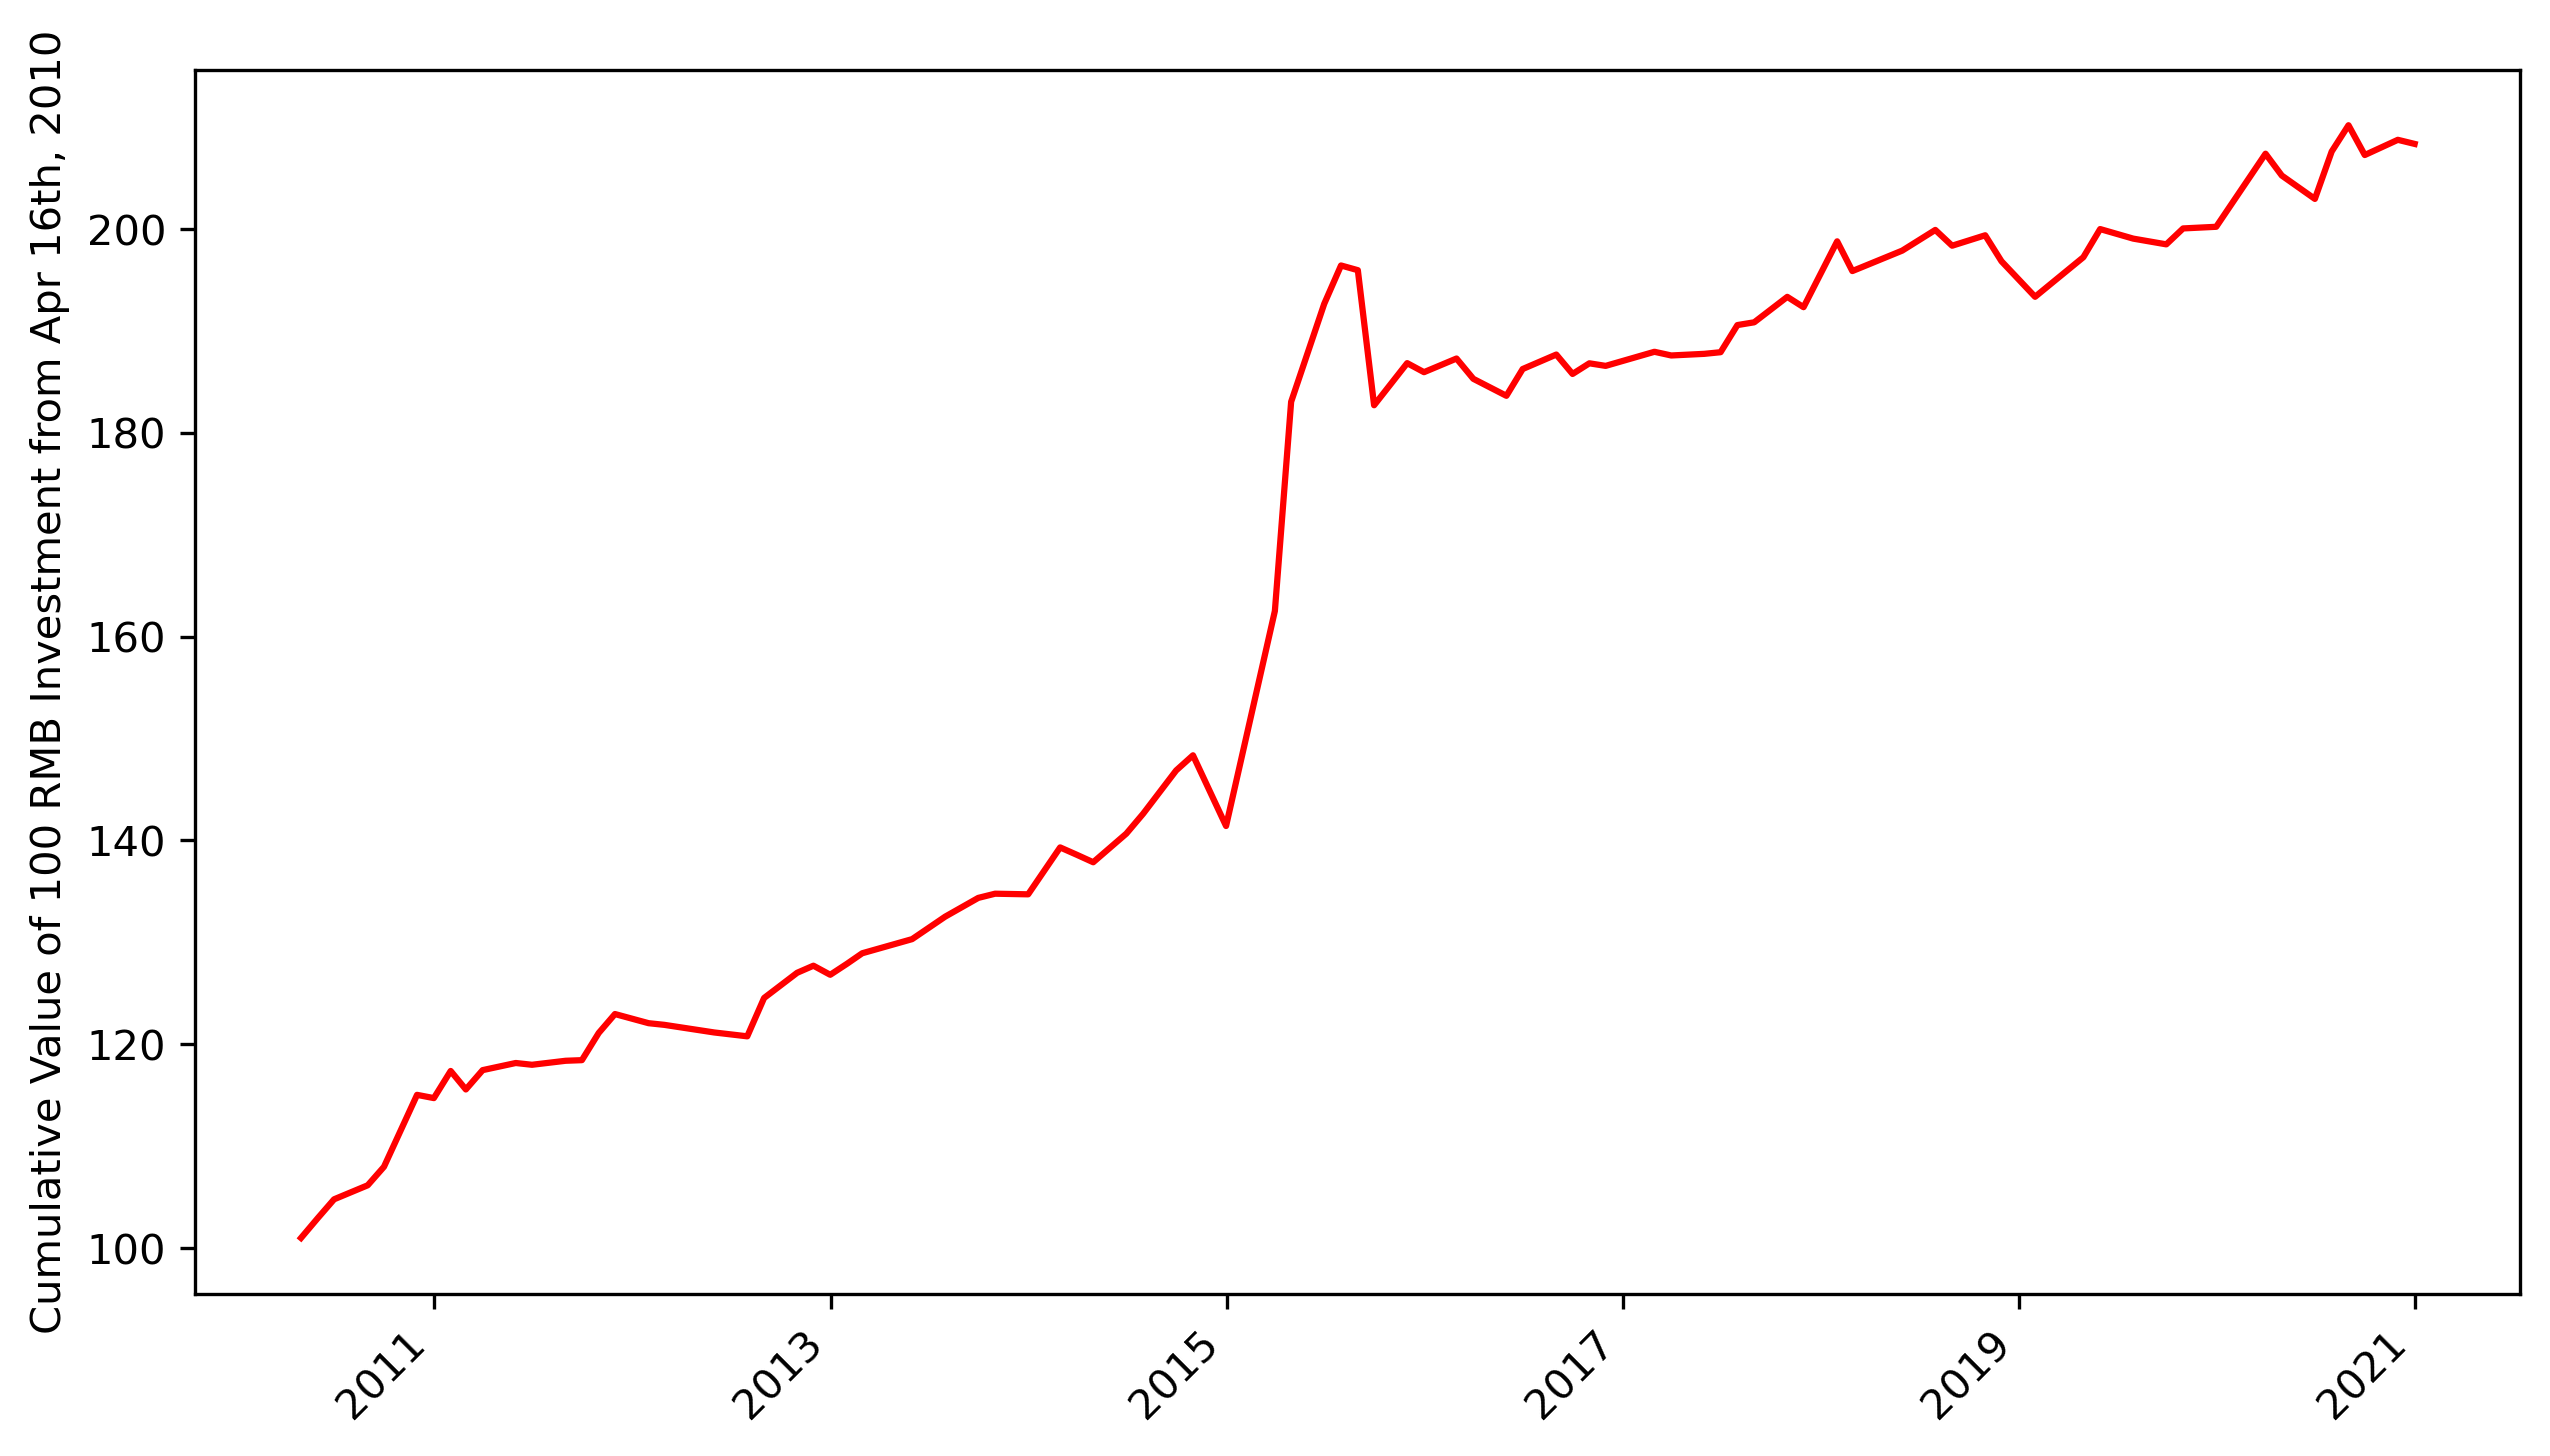

In [49]:
fig = plt.figure(figsize=(10,6))
ax1 = ((df_port_FBABCVW.loc[:, "CumRet%"]+1)*100).plot(c="r")
figure1 = ax1.figure 
figure1.autofmt_xdate() 
figure1.show()

tic = ['2011-01-01', '2013-01-01', '2015-01-01',
'2017-01-01','2019-01-01','2021-01-01']
lab = ['2011', '2013', '2015',
'2017','2019','2021']
plt.xticks(ticks=tic, labels=lab, rotation=45, fontsize=10)
plt.ylabel("Cumulative Value of 100 RMB Investment from Apr 16th, 2010", fontsize=10)
plt.xlabel("", fontsize=10) 

plt.savefig('result/figure10.jpg') 